# Overview

## How did public sentiment evolve toward COVID-19 vaccines on Twitter from 2020 to 2021?

# Part 1: Exploratory Data Analysis

In [2]:
import re
import string
import numpy as np
import pandas as pd
from collections import Counter
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## EDA of dataset 1: covid-19_tweets_with_sentiment.csv

The dataset contains 6,000 COVID-19–related tweets, where each row represents one unique tweet. Each observation includes a tweet identifier (tweet_id), a categorical label (label) serving as the target variable, and the raw tweet text (tweet_text). Several example rows are displayed above to illustrate the structure and content of the data. The dataset shape is (6000, 3), which meets the course recommendation of having at least 5,000 samples to ensure reliable model training and tuning. 

### Data Overview

In [7]:
# load dataset and overview
df = pd.read_csv("/Users/yangshuting/Desktop/UChicago/courses/winter_2026/MACS_30100_ML/group_project/covid-19_vaccine_tweets_with_sentiment.csv", encoding="latin1")
df.head(30) # display several examples of the data (e.g., several rows in the dataframe).

,tweet_id,label,tweet_text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""dont hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."
5,1.351285e+18,1,Still want to take the #jab?\n#PfizerBioNTech\...
6,1.377333e+18,2,"This time, Aerolíneas flight AR1068 goes to Mo..."
7,1.363344e+18,3,#Covaxin effective against mutant virus strain...
8,1.372580e+18,3,Safe and effective. #OxfordAstraZeneca
9,1.367507e+18,2,The day after the #Moderna #COVID19Vaccine... ...


### Data Size

In [17]:
# data size
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")

Dataset shape: (6000, 3)
Number of samples: 6000
Number of features: 3


### Data Features

In [18]:
# data features: textual data
print(f"\nColumn names and dtypes:")
print(df.dtypes)


Column names and dtypes:
tweet_id      float64
label           int64
tweet_text     object
dtype: object


## Data Preprocessing
Several basic preprocessing checks were conducted before modeling. 
1. Duplicates: we examined duplicate entries in the tweet_text column to identify repeated content. Only 9 duplicate tweets were found out of 6,000 total samples (about 0.15% of the dataset), indicating that duplication was very rare, so duplicates were not removed. 
2. Missing Values: We also checked for missing values in the text data and found no missing entries in the tweet_text column, meaning no imputation or interpolation was necessary. Because the data consist of raw text rather than numerical measurements, traditional outlier detection was not applicable in this context. 


In [19]:
# check duplicates in tweet_text column
col = "tweet_text"
duplicated_counts = df[col].duplicated().value_counts()
total = len(df)
duplicate_count = df[col].duplicated().sum()
duplicate_pct = (duplicate_count / total) * 100

print(f"Duplicate counts in column '{col}':")
print(duplicated_counts)
print(f"Duplicate percentage: {duplicate_count}/{total} = {duplicate_pct:.2f}%")
# note: the duplicate rate is relatively low and can be ignored for this analysis.

Duplicate counts in column 'tweet_text':
tweet_text
False    5991
True        9
Name: count, dtype: int64
Duplicate percentage: 9/6000 = 0.15%


In [20]:
# check missing values
null_sum_text_col = df[col].isnull().sum()
print(f"Missing values in '{col}': {null_sum_text_col}")
# note: missing values can be ignored.

Missing values in 'tweet_text': 0


### Text Cleaning and Normalization

- In addition to basic data quality checks, we applied several text-specific preprocessing steps to clean and standardize the tweet content. 
- All tweet text was converted to lowercase to ensure consistent token matching. Common English contractions (e.g., “can’t” ->“cannot”, “won’t” -> “will not”) were expanded to preserve semantic meaning while reducing vocabulary fragmentation. We removed HTML tags, URLs, and email addresses, as these elements do not contribute meaningful information for sentiment classification. Non-alphabetic characters and punctuation were also removed, and extra whitespace was normalized. 
- After cleaning, we verified that no tweets were reduced to empty strings, and all 6,000 tweets were retained for analysis.

In [21]:
# text cleaning functions:
def decontracted(text):
    # Handle non-string inputs
    if not isinstance(text, str):
        return ""

    # expand common English contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


def clean_text_single(text):
    # handle non-string inputs
    if not isinstance(text, str):
        return ""

    # convert text to lowercase
    text = text.lower()

    # expand contractions
    text = decontracted(text)

    # remove HTML tags
    text = BeautifulSoup(text, "lxml").get_text().strip()

    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # remove email addresses
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', text)

    # keep only alphabetic characters and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # remove punctuation characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text



In [22]:
# clean the text in 'tweet_text' column
df['cleaned_tweet'] = df['tweet_text'].apply(clean_text_single)

# remove rows where cleaning resulted in empty text
df = df[df['cleaned_tweet'].str.len() > 0].reset_index(drop=True)
print(f"Samples remaining: {len(df)}")


Samples remaining: 6000


### Text Length Analysis


- To better understand the structure of the text data after preprocessing, we conducted an exploratory analysis of tweet length measured in terms of both number of characters and number of words. 
- At the character level, tweets contained an average of approximately 163 characters, with a median of 166 characters. Most tweets fell between 99 and 229 characters (interquartile range), indicating moderate-length text after cleaning. Although a small number of tweets were substantially longer (up to 776 characters), these cases were rare and did not dominate the overall distribution, suggesting no need for length-based filtering or truncation. 
- At the word level, tweets contained an average of approximately 26 words, with most tweets falling between 15 and 36 words, further confirming that the dataset consists of moderately sized text suitable for standard text vectorization techniques such as bag-of-words or TF-IDF representations. 
- The histogram and boxplot together show that tweet length distributions are broadly similar across sentiment classes, with substantial overlap. Negative tweets tend to be slightly longer on average, exhibiting a higher median word count and greater variability than neutral and positive tweets, while positive tweets generally have the shortest median length. However, the overlapping interquartile ranges and long tails across all classes indicate that no sentiment category is clearly separable based on word count alone. This suggests that while tweet length shows modest class-level differences, sentiment is primarily conveyed through lexical content and word choice rather than message length, supporting the use of content-based text representations for modeling.

In [36]:
# number of characters

df['text_length_chars'] = df['cleaned_tweet'].apply(len)

# number of words

df['text_length_words'] = df['cleaned_tweet'].apply(lambda x: len(x.split()))
label_map = {1: "Negative", 2: "Neutral", 3: "Positive"}
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

# text length statistics
print("Overall text length (characters):")
print(df['text_length_chars'].describe())
print("\nOverall text length (words):")
print(df['text_length_words'].describe())
# text length (words) by sentiment
print("\nText Length (words) by Sentiment")
for label_val in sorted(label_map.keys()):
    lengths = df[df['label'] == label_val]['text_length_words']
    print(f"{label_map[label_val]}: mean={lengths.mean():.1f}, median={lengths.median():.0f}, "
          f"std={lengths.std():.1f}, min={lengths.min()}, max={lengths.max()}")


Overall text length (characters):
count    6000.000000
mean      162.593833
std        74.991907
min        12.000000
25%        99.000000
50%       166.000000
75%       229.000000
max       776.000000
Name: text_length_chars, dtype: float64

Overall text length (words):
count    6000.000000
mean       25.649167
std        12.464790
min         2.000000
25%        15.000000
50%        26.000000
75%        36.000000
max        96.000000
Name: text_length_words, dtype: float64

Text Length (words) by Sentiment
Negative: mean=29.2, median=29, std=12.6, min=3, max=62
Neutral: mean=25.9, median=26, std=12.3, min=2, max=96
Positive: mean=24.4, median=24, std=12.6, min=2, max=65


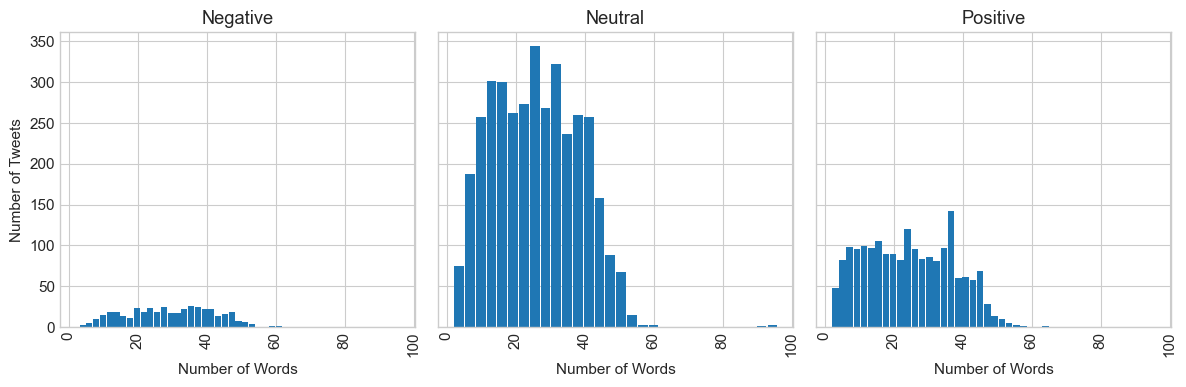

In [27]:
# histogram of text length (words) by sentiment with labels
df.hist(
    column='text_length_words',
    by='label',
    bins=30,
    figsize=(12, 4),
    rwidth=0.9,
    layout=(1, 3),
    sharex=True,
    sharey=True
)

# replace numeric titles with sentiment labels
for ax, label_val in zip(plt.gcf().axes, sorted(label_map.keys())):
    ax.set_title(label_map[label_val])  # show Negative / Neutral / Positive
    ax.set_xlabel('Number of Words')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()


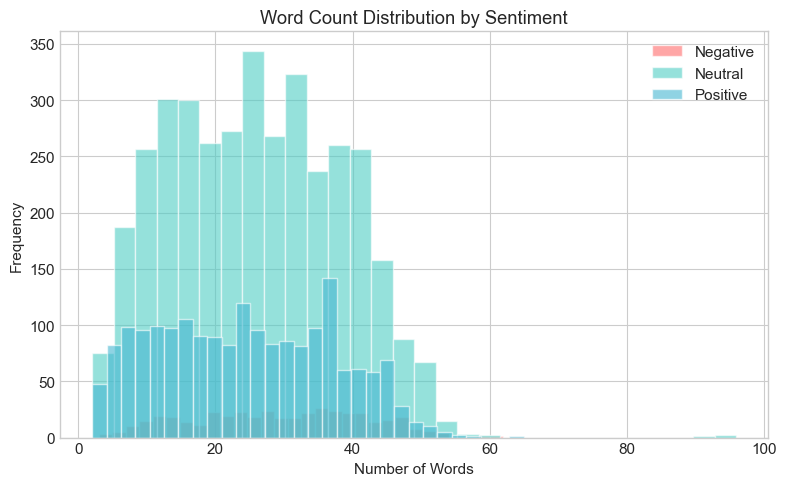

In [34]:
# (Combined) Histogram of Text Length by Sentiment
plt.figure(figsize=(8, 5))

for label_val, color in zip(sorted(label_map.keys()), colors):
    subset = df[df['label'] == label_val]['text_length_words']
    plt.hist(subset, bins=30, alpha=0.6, color=color, label=label_map[label_val], edgecolor='white')

plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Word Count Distribution by Sentiment')
plt.legend()
plt.tight_layout()
plt.show()


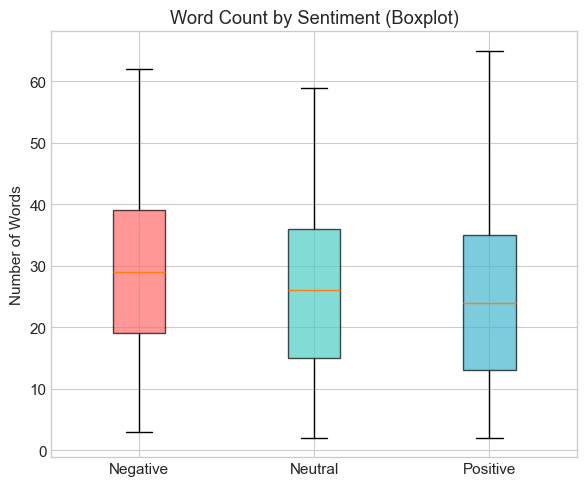

In [35]:
# Boxplot of Text Length by Sentiment
plt.figure(figsize=(6, 5))

# Prepare data for boxplot
bp_data = [df[df['label'] == k]['text_length_words'].values for k in sorted(label_map.keys())]

# Create boxplot
bp = plt.boxplot(
    bp_data,
    labels=[label_map[k] for k in sorted(label_map.keys())],
    patch_artist=True,
    showfliers=False
)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Number of Words')
plt.title('Word Count by Sentiment (Boxplot)')
plt.tight_layout()
plt.show()

### Target Variable Distribution

- The target variable is a three-class sentiment label with categories Negative, Neutral, and Positive. 
- The class distribution is imbalanced: Neutral tweets form the majority class with 3,680 samples (61.3%), followed by Positive tweets with 1,900 samples (31.7%), while Negative tweets are the minority class with only 420 samples (7.0%). The resulting imbalance ratio between the largest and smallest classes is approximately 8.76, indicating a substantial class imbalance.
- This class imbalance suggests that overall accuracy alone may be misleading. Because negative tweets are underrepresented in the original dataset, we augmented the training data with additional high-quality negative tweets from an external dataset to improve the model’s ability to learn negative sentiment. Exploratory analysis of this second dataset is presented later.

In [30]:
# map numeric sentiment labels to human-readable names
label_map = {1: "Negative", 2: "Neutral", 3: "Positive"}

# create a new column with sentiment names based on the numeric labels
df['label_name'] = df['label'].map(label_map)

# count the number of samples per label and sort by label index
label_counts = df['label'].value_counts().sort_index()

# print count and percentage for each label
print("Label distribution:")
for label_val, count in label_counts.items():
    pct = count / len(df) * 100
    print(f"{label_map[label_val]} (label={label_val}): {count} ({pct:.1f}%)")

# compute class imbalance ratio
majority = label_counts.max()   # largest class size
minority = label_counts.min()   # smallest class size
print(f"\nImbalance ratio (majority/minority): {majority/minority:.2f}")


Label distribution:
Negative (label=1): 420 (7.0%)
Neutral (label=2): 3680 (61.3%)
Positive (label=3): 1900 (31.7%)

Imbalance ratio (majority/minority): 8.76


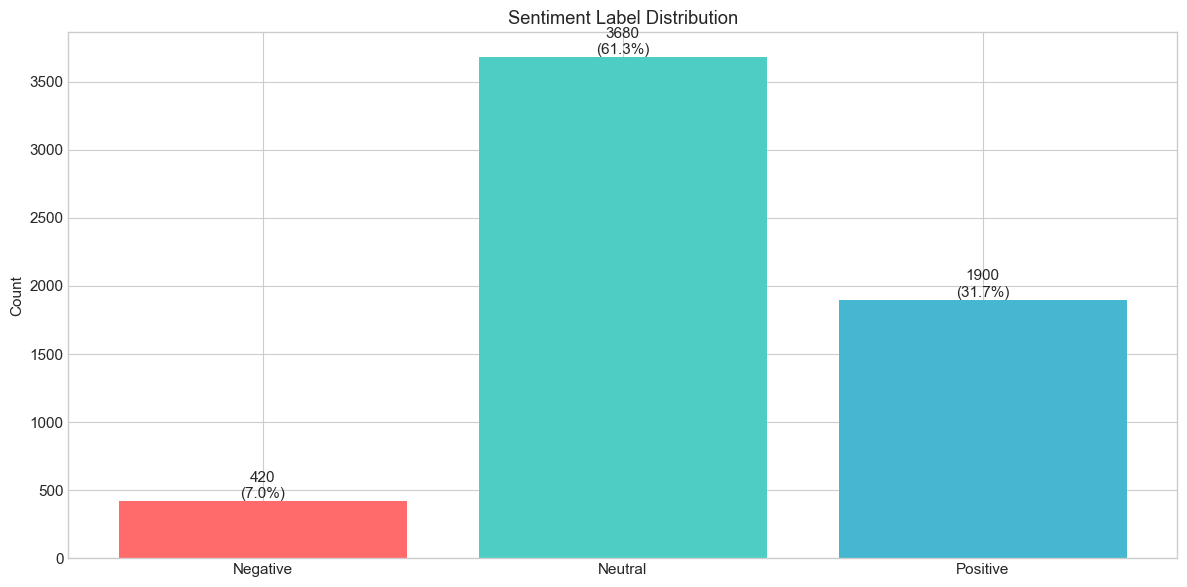

In [31]:
# target variable distribution visualization

labels = [label_map[k] for k in sorted(label_map.keys())]
counts = [label_counts.get(k, 0) for k in sorted(label_map.keys())]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']

bars = plt.bar(labels, counts, color=colors)

plt.ylabel("Count")
plt.title("Sentiment Label Distribution")

# add count and percentage on top of each bar
total = len(df)
for bar in bars:
    height = bar.get_height()
    pct = height / total * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}\n({pct:.1f}%)",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


### train/val/test (70/10/20) Split

The table and bar chart show that the sentiment label distribution is consistent across the training, validation, and test sets. In all three splits, neutral tweets make up about 61% of the data, positive tweets account for roughly 32%, and negative tweets remain the smallest class at around 7%. The near-identical proportions across splits indicate that the data were split in a stratified manner, preserving the original class imbalance. This consistency is important for fair model evaluation, as it ensures that performance differences between splits are not driven by changes in class composition. As a result, model performance on the validation and test sets can be interpreted as reflecting true generalization rather than artifacts of the data split.

In [32]:
# split data into train/val/test (70/10/20)
X_temp, X_test_split, y_temp, y_test_split = train_test_split(
    df['cleaned_tweet'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

# split remaining 80% into train and val
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_temp, y_temp,
    test_size=0.125, random_state=42, stratify=y_temp  # 0.125 of 80% = 10% overall
)

# check split sizes
print(f"Total samples: {len(df)}")
print(f"Train set: {len(X_train_split)} ({len(X_train_split)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val_split)} ({len(X_val_split)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test_split)} ({len(X_test_split)/len(df)*100:.1f}%)")

Total samples: 6000
Train set: 4200 (70.0%)
Validation set: 600 (10.0%)
Test set: 1200 (20.0%)


Train split:
Negative: 294 (7.0%)
Neutral: 2576 (61.3%)
Positive: 1330 (31.7%)
Validation split:
Negative: 42 (7.0%)
Neutral: 368 (61.3%)
Positive: 190 (31.7%)
Test split:
Negative: 84 (7.0%)
Neutral: 736 (61.3%)
Positive: 380 (31.7%)


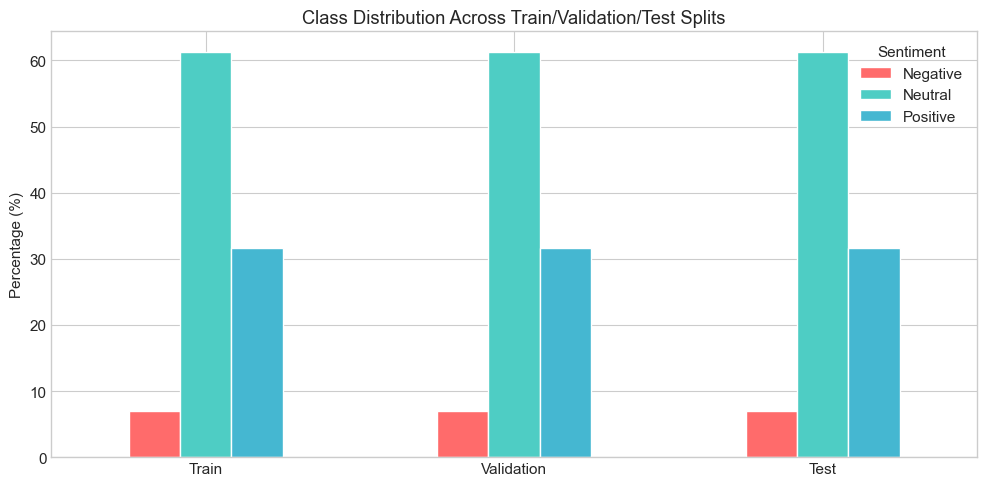

In [33]:
# Check how sentiment labels are distributed across train/val/test splits

splits = {'Train': y_train_split, 'Validation': y_val_split, 'Test': y_test_split}

split_dist = {}

for split_name, y_split in splits.items():
    counts = y_split.value_counts().sort_index()
    pcts = counts / len(y_split) * 100
    split_dist[split_name] = pcts

    print(f"{split_name} split:")
    for label_val in sorted(label_map.keys()):
        print(
            f"{label_map[label_val]}: "
            f"{counts.get(label_val, 0)} "
            f"({pcts.get(label_val, 0):.1f}%)"
        )

# Convert to dataframe for plotting
split_df = pd.DataFrame(split_dist).T
split_df.columns = [label_map[c] for c in split_df.columns]

# Plot class distribution across splits
fig, ax = plt.subplots(figsize=(10, 5))
split_df.plot(
    kind='bar',
    ax=ax,
    color=colors,
    edgecolor='white'
)

ax.set_ylabel('Percentage (%)')
ax.set_title('Class Distribution Across Train/Validation/Test Splits')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('eda_03_split_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


### Tf-idf Vectorizer

- We represented the tweet text using TF-IDF features with both unigrams and bigrams (n-gram range = 1–2). Although the maximum feature size was set to 15,000, the final vocabulary contained 5,493 features, reflecting the most informative terms in the dataset. All features are numerical and correspond to TF-IDF scores.
- After vectorization, the resulting feature matrices have shapes of (4200, 5493) for the training set, (600, 5493) for the validation set, and (1200, 5493) for the test set. The feature matrices are highly sparse, with a sparsity level of 99.68%, which is expected for text data. The ratio of samples to features is approximately 0.76, indicating a high-dimensional feature space.
- This representation is well suited for linear models, which are designed to handle sparse, high-dimensional data effectively. At the same time, it motivates careful regularization and parameter tuning, particularly when applying more complex models, to avoid overfitting.

In [37]:
# feature space and vectorization:

# define stopwords
stopwords_list = list(set([
    'br','the','i','me','my','myself','we','our','ours','ourselves','you',
    "you're","you've","you'll","you'd",'your','yours','yourself','yourselves',
    'he','him','his','himself','she',"she's",'her','hers','herself','it',
    "it's",'its','itself','they','them','their','theirs','themselves','what',
    'which','who','whom','this','that',"that'll",'these','those','am','is',
    'are','was','were','be','been','being','have','has','had','having','do',
    'does','did','doing','a','an','the','and','but','if','or','because','as',
    'until','while','of','at','by','for','with','about','against','between',
    'into','through','during','before','after','above','below','to','from',
    'up','down','in','out','on','off','over','under','again','further','then',
    'once','here','there','when','where','why','how','all','any','both','each',
    'few','more','most','other','some','such','only','own','same','so','than',
    'too','very','s','t','can','will','just','don',"don't",'should',
    "should've",'now','d','ll','m','o','re','ve','y','ain','aren',"aren't",
    'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",
    'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",
    'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",
    'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"
]))

# setup tfidf vectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=stopwords_list,
    max_df=0.9,
    min_df=3,
    ngram_range=(1, 2),
    max_features=15000
)

# fit and transform
X_train_vec = vectorizer.fit_transform(X_train_split)
X_val_vec = vectorizer.transform(X_val_split)
X_test_vec = vectorizer.transform(X_test_split)

feature_names = vectorizer.get_feature_names_out()

print(f"Feature extraction method: TF-IDF")
print(f"N-gram range: (1, 2)")
print(f"Max features: 15,000")
print(f"Actual number of features: {len(feature_names)}")
print(f"Feature type: All numerical (TF-IDF scores)")
print(f"\nFeature matrix shapes:")
print(f"Train: {X_train_vec.shape}")
print(f"Validation: {X_val_vec.shape}")
print(f"Test: {X_test_vec.shape}")
print(f"\nSparsity: {(1 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])) * 100:.2f}%")
print(f"#samples vs #features ratio = {X_train_vec.shape[0] / X_train_vec.shape[1]:.2f}")


Feature extraction method: TF-IDF
N-gram range: (1, 2)
Max features: 15,000
Actual number of features: 5493
Feature type: All numerical (TF-IDF scores)

Feature matrix shapes:
Train: (4200, 5493)
Validation: (600, 5493)
Test: (1200, 5493)

Sparsity: 99.68%
#samples vs #features ratio = 0.76


#### Top words per class visualization


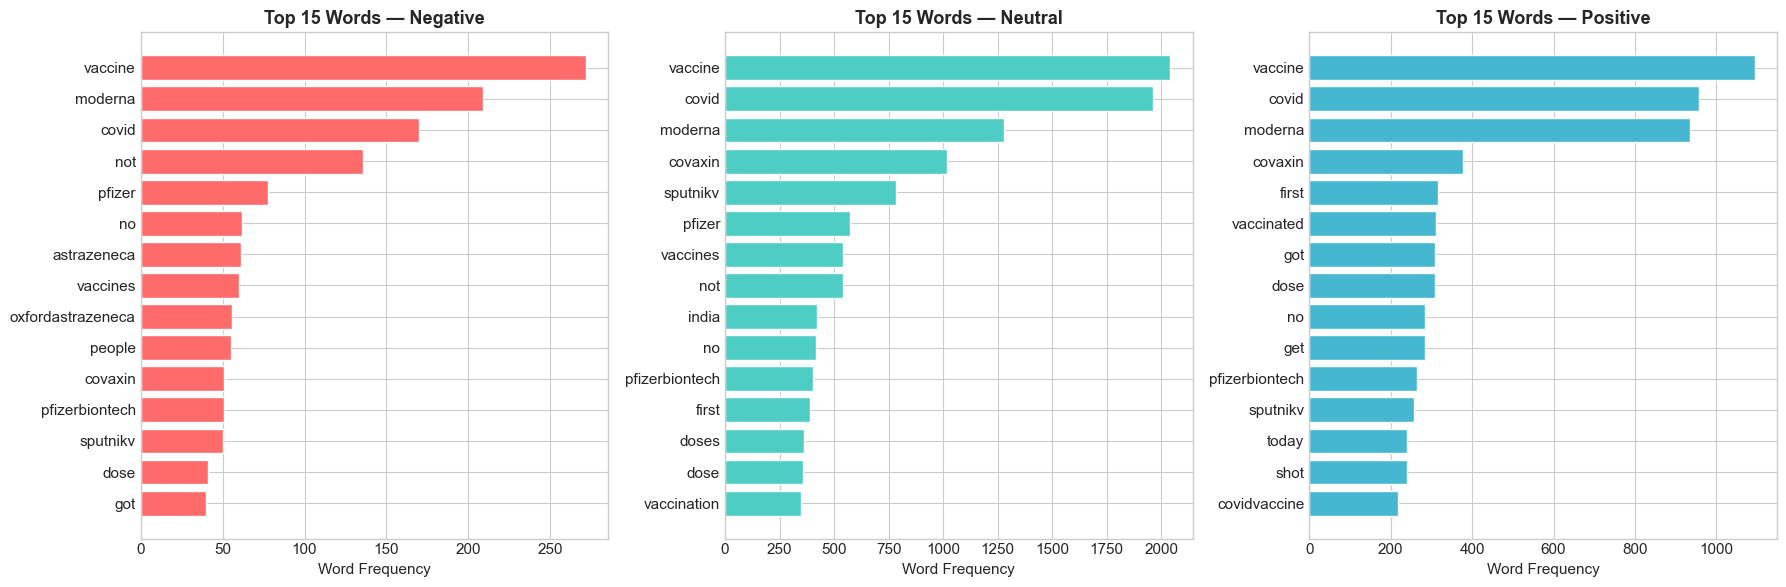

In [38]:
# Create a CountVectorizer to convert text into word counts
# Only consider words that appear in at least 3 documents and in less than 90% of documents
count_vec = CountVectorizer(
    lowercase=True,          
    stop_words=stopwords_list, 
    max_df=0.9,             
    min_df=3,              
    ngram_range=(1, 1)       
)

# Fit the vectorizer and transform the cleaned tweets into a document-term matrix
X_count = count_vec.fit_transform(df['cleaned_tweet'])

# Get the list of all words/features
count_features = count_vec.get_feature_names_out()

# Create subplots: one for each sentiment class
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop over each class (Negative, Neutral, Positive)
for idx, (label_val, color) in enumerate(zip(sorted(label_map.keys()), colors)):

    # Create a mask for all rows belonging to the current class
    mask = (df['label'] == label_val).values

    # Sum word counts for this class
    class_word_counts = X_count[mask].sum(axis=0).A1

    # Get indices of the top 15 words
    top_idx = class_word_counts.argsort()[-15:][::-1]

    # Get the words and their counts
    words = [count_features[i] for i in top_idx]
    counts = [class_word_counts[i] for i in top_idx]

    # Plot a horizontal bar chart for the class
    axes[idx].barh(range(len(words)), counts, color=color, edgecolor='white')
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].invert_yaxis()  # largest at the top
    axes[idx].set_xlabel('Word Frequency')
    axes[idx].set_title(f'Top 15 Words — {label_map[label_val]}', fontsize=13, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('eda_04_top_words_per_class.png', dpi=150, bbox_inches='tight')
plt.show()


**Interpretation of Frequent Words by Sentiment**

- The top-word frequency plots show that all three sentiment classes share a common topical focus on COVID-19 and vaccines, as terms such as “vaccine,” “covid,” “moderna,” and “pfizer” appear frequently across negative, neutral, and positive tweets. This suggests that sentiment differences are not driven by topic alone, but by how these topics are discussed.
- Negative tweets are more likely to include negation-related words such as “not” and “no,” as well as references to specific vaccine brands, which may reflect skepticism or criticism. Neutral tweets tend to emphasize informational or descriptive terms, including vaccine names and geographic references (e.g., “india”), consistent with reporting or news-style content. In contrast, positive tweets more frequently contain action-oriented words such as “vaccinated,” “got,” “dose,” and “shot,” reflecting personal experiences or successful vaccination events.
- Overall, these patterns indicate that sentiment is expressed through lexical choices and context rather than through distinct topics. This observation further supports the use of content-based text features, such as TF-IDF representations, which can capture these subtle differences in word usage across sentiment classes.

#### Shared vs Distinctive Words Across Sentiments

In [39]:
top_n = 200 # Number of top words to consider per class
class_top_words = {} 

# Loop through each sentiment class
for label_val in sorted(label_map.keys()):
    # Mask for rows belonging to the current class
    mask = (df['label'] == label_val).values
    
    # Sum word counts for this class
    class_word_counts = X_count[mask].sum(axis=0).A1
    
    # Get indices of top_n words
    top_idx = class_word_counts.argsort()[-top_n:][::-1]
    
    # Store the words as a set for easy comparison
    class_top_words[label_map[label_val]] = set(count_features[i] for i in top_idx)


# Words that appear in the top N of all classes
all_shared = class_top_words['Negative'] & class_top_words['Neutral'] & class_top_words['Positive']

# Words unique to each class
neg_unique = class_top_words['Negative'] - class_top_words['Neutral'] - class_top_words['Positive']
neu_unique = class_top_words['Neutral'] - class_top_words['Negative'] - class_top_words['Positive']
pos_unique = class_top_words['Positive'] - class_top_words['Negative'] - class_top_words['Neutral']


print(f"Words shared across all 3 classes (top {top_n}): {len(all_shared)}")
print(f"Examples: {list(all_shared)[:10]}")

print(f"\nWords unique to Negative: {len(neg_unique)}")
print(f"Examples: {list(neg_unique)[:10]}")

print(f"Words unique to Neutral: {len(neu_unique)}")
print(f"Examples: {list(neu_unique)[:10]}")

print(f"Words unique to Positive: {len(pos_unique)}")
print(f"Examples: {list(pos_unique)[:10]}")


Words shared across all 3 classes (top 200): 101
Examples: ['day', 'pfizerbiontech', 'feel', 'covid', 'family', 'approved', 'many', 'really', 'work', 'india']

Words unique to Negative: 71
Examples: ['later', 'found', 'red', 'death', 'several', 'another', 'big', 'vax', 'injection', 'reactions']
Words unique to Neutral: 48
Examples: ['produce', 'stay', 'administered', 'help', 'forced', 'usa', 'company', 'production', 'trudeau', 'drharshvardhan']
Words unique to Positive: 56
Examples: ['team', 'protect', 'appointment', 'moscow', 'lives', 'wait', 'icmr', 'normal', 'strain', 'volunteers']


**Interpretation of Shared and Class-Specific Vocabulary**
- The analysis of shared and class-specific words shows that a substantial portion of the vocabulary is common across all three sentiment classes. Among the top 200 words per class, 101 words are shared across negative, neutral, and positive tweets, consisting largely of general COVID-19 and vaccination terms (e.g., “vaccine,” “cases,” “day,” “phase”). This reinforces the observation that sentiment differences are not driven by topic, as most tweets discuss similar subject matter.
- At the same time, each sentiment class also exhibits a set of distinctive words. Negative tweets contain more symptom-related and emotionally charged terms (e.g., “aches,” “headache,” “fatigue,” “fever”), suggesting expressions of discomfort or adverse experiences. Neutral tweets include more informational or administrative language (e.g., “administered,” “public,” “children,” “ema”), consistent with reporting or news-style content. Positive tweets are more likely to feature affective and action-oriented words (e.g., “happy,” “thanks,” “amazing,” “vaccinated”), reflecting positive personal experiences or outcomes.
- Overall, this pattern highlights that sentiment is conveyed through specific lexical context, even when the underlying topic is shared. This further supports the use of TF-IDF features, which can downweight common terms while emphasizing words that are more distinctive of each sentiment class.

## EDA of Dataset 2: external_tweets.csv


Since the negative class in the original dataset is underrepresented, we decided to augment the training data with high‑quality negative tweets from an external dataset to improve the model’s ability to learn negative sentiment. The EDA for this dataset is therefore targeted rather than comprehensive, focusing on whether it provides reliable and compatible negative samples rather than replicating the full exploratory pipeline like what we did for Dataset 1.


### Data Overview

The external dataset contains 10,001 tweets with four variables: a unique tweet ID, cleaned tweet text (safe_text), a sentiment label, and an annotator agreement score. This moderate dataset size makes it suitable for data augmentation without overpowering the original training data. Importantly, the inclusion of an agreement score allows us to assess label reliability and selectively extract high-confidence negative tweets. Because the goal of this EDA is not to fully replicate the original pipeline but to evaluate whether this dataset can provide reliable negative samples, we focus on its structure, label quality, and annotation confidence.

In [42]:
# load the external data
df_external = pd.read_csv("/Users/zehanli/Course_Uchicago/Winter_2025/MACS30100/Final_project/external_tweets.csv")
df_external.head() # display several examples of the data (e.g., several rows in the dataframe).

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


#### Data Size

In [43]:
print(f"Dataset shape: {df_external.shape}")
print(f"Number of samples: {len(df_external)}")
print(f"Number of features: {df_external.shape[1]}")

Dataset shape: (10001, 4)
Number of samples: 10001
Number of features: 4


#### Data Features

In [44]:
# data features: textual data
print(f"\nColumn names and dtypes:")
print(df_external.dtypes)


Column names and dtypes:
tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object


## Data Preprocessing

In [45]:
# missing values per column
print("Missing values:")
print(df_external.isnull().sum())

# duplicates based on tweet text
col = "safe_text"
dup_count = df_external[col].duplicated().sum()
total = len(df_external)

print(f"\nDuplicate texts in '{col}': {dup_count}/{total} ({dup_count/total*100:.2f}%)")


Missing values:
tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

Duplicate texts in 'safe_text': 343/10001 (3.43%)


In [46]:
# drop duplicates
df_external = df_external.drop_duplicates(subset=["safe_text"]).reset_index(drop=True)
print("After dropping duplicate texts:", df_external.shape)

After dropping duplicate texts: (9658, 4)


Dataset 2 has very low missingness in the key text field (safe_text: 0 missing) and only minor missingness in metadata (label: 1 missing, agreement: 2 missing). We also found a small duplicate rate in the tweet text (3.43%), meaning some tweets appear multiple times. Because duplicates can overweight repeated messages and bias downstream feature learning, we removed duplicate entries based on safe_text, reducing the dataset from 10,001 to 9,658 unique tweets. This ensures each tweet contributes at most once when we later extract high-quality negative samples.

### Target Variable Distribution

The external dataset contains 9,656 unique tweets after deduplication, with a moderately imbalanced label distribution. Negative tweets account for 1,027 observations (10.6%), while neutral (48.6%) and positive (40.8%) tweets make up the majority of the data. Given our goal of augmenting underrepresented negative samples, we focus subsequent analyses on the negative subset only.

In [47]:
# target variable distribution
label_counts = df_external["label"].value_counts().sort_index()
total = len(df_external)

print("Label Distribution:")
print(f"-1.0 (Negative): {label_counts.get(-1.0, 0):>5} ({label_counts.get(-1.0, 0)/total*100:.1f}%)")
print(f" 0.0 (Neutral):  {label_counts.get(0.0, 0):>5} ({label_counts.get(0.0, 0)/total*100:.1f}%)")
print(f" 1.0 (Positive): {label_counts.get(1.0, 0):>5} ({label_counts.get(1.0, 0)/total*100:.1f}%)")


Label Distribution:
-1.0 (Negative):  1027 (10.6%)
 0.0 (Neutral):   4690 (48.6%)
 1.0 (Positive):  3939 (40.8%)


In [48]:
# keep only negative tweets (external encoding: -1 = negative)
neg_only = df_external[df_external["label"] == -1].copy()
print("Negative-only rows:", len(neg_only))

Negative-only rows: 1027


#### High-Quality Negative Tweets Extractions, Cleaning, and Normalization

- Within the negative-labeled tweets, agreement scores indicate generally strong annotator consensus. Agreement values range from 0.33 to 1.00, with a mean of 0.72, suggesting that most negative labels are supported by a clear majority of annotators. Notably, both the 25th percentile and the median agreement are 0.67, indicating that at least half of the negative tweets achieve two-thirds or higher annotator agreement. Furthermore, the upper quartile reaches full agreement (1.00), showing that a substantial subset of negative tweets is unanimously labeled. Overall, this distribution supports the use of an agreement threshold of 0.66 as a data-driven cutoff for extracting high-quality negative samples, balancing annotation reliability and sample coverage.
- Applying the agreement-based filtering criterion (label = −1 and agreement >= 0.66) yields 797 high-quality negative tweets from the external dataset. These samples represent negative sentiment instances that are supported by at least a two-thirds majority of annotators, ensuring a meaningful level of label reliability. By restricting augmentation to this high-confidence subset and remapping labels to match our internal encoding, we reduce the risk of introducing noisy or ambiguous labels into the training data while effectively increasing the representation of negative sentiment for downstream modeling.

In [49]:
# see aggreement distribution
neg_only["agreement"].describe()

count    1027.000000
mean        0.715352
std         0.252364
min         0.333333
25%         0.666667
50%         0.666667
75%         1.000000
max         1.000000
Name: agreement, dtype: float64

In [50]:
# extract high quality negative tweets from the external data
# label = -1 and agreement >= 0.66
# display the examples of the high quality negative samples

# filter high-quality negative samples from external dataset
df_neg_hq = df_external[
    (df_external["label"] == -1.0) &
    (df_external["agreement"] >= 0.66)
].copy()

# rename column to match our format
df_hq = df_neg_hq.rename(columns={"safe_text": "tweet_text"})

# map label to our encoding (1 = negative)
df_hq["label"] = 1

print("High-quality negative samples:", len(df_hq))
df_hq.head()

High-quality negative samples: 797


,tweet_id,tweet_text,label,agreement
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",1,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,1,1.0
24,89AB846O,<user> #CDC lied and hid data that black boys ...,1,1.0
25,XSXFN1C8,<user> vaccines causing autism,1,1.0
47,G1CJ54KD,<user> I'm not vaccinating my kids lol,1,1.0


#### Apply text cleaning functions

The extracted high-quality negative tweets were cleaned using the same preprocessing pipeline as the original data. These cleaned samples were then appended to the original training set to increase negative-class representation while maintaining consistent preprocessing and feature construction across all training data.

In [51]:
print("df_hq before cleaning:", len(df_hq))
df_hq["tweet_text"].head()

df_hq before cleaning: 797


2     #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3     I mean if they immunize my kid with something ...
24    <user> #CDC lied and hid data that black boys ...
25                       <user> vaccines causing autism
47               <user> I'm not vaccinating my kids lol
Name: tweet_text, dtype: object

In [52]:
# add a progress bar
def clean_text(text_list):
    return [clean_text_single(t) for t in tqdm(text_list, desc="Cleaning text")]

In [53]:
# applying the cleaning functions to the high-quality negative samples and filter out any empty cleaned tweets
df_hq["cleaned_tweet"] = clean_text(df_hq["tweet_text"].tolist())
df_hq = df_hq[df_hq["cleaned_tweet"].str.len() > 0].reset_index(drop=True)


Cleaning text: 100%|██████████| 797/797 [00:00<00:00, 9926.03it/s]


### Augmentation and Final Split

- After augmenting the training set with 797 high-quality negative tweets, the training size increased from 4,200 to 4,997 samples, confirming that augmentation was applied correctly and only to the training split. 
- This substantially increased the representation of the negative class, which rose to 21.8% of the training data, while neutral and positive classes now account for 51.6% and 26.6%, respectively. This shift reduces the original class imbalance and provides the model with more negative examples without overwhelming the dataset. 
- Importantly, all added samples contain valid cleaned text (no missing values), with cleaned tweet lengths well within a reasonable range (median = 94 characters), indicating that preprocessing was successful and the augmented data are suitable for model training.
- Therefore,  the final training set in our study is augmented with external negative samples, while the validation and test sets come only from the original dataset (no external data).

In [54]:
# merge the high-quality negative samples with the original training dataset
X_train_aug = pd.concat([pd.Series(X_train_split), df_hq["cleaned_tweet"]], ignore_index=True)
y_train_aug = pd.concat([pd.Series(y_train_split), df_hq["label"]], ignore_index=True)

print("Train before augmentation:", len(X_train_split))
print("Train after augmentation:", len(X_train_aug))
print("\nTraining label distribution AFTER augmentation:")
print(y_train_aug.value_counts(normalize=True).sort_index().round(3))

Train before augmentation: 4200
Train after augmentation: 4997

Training label distribution AFTER augmentation:
label
1    0.218
2    0.516
3    0.266
Name: proportion, dtype: float64


In [55]:
df_hq["cleaned_tweet"].isna().sum()
df_hq["cleaned_tweet"].str.len().describe()

count    797.000000
mean      90.908407
std       27.790094
min       12.000000
25%       72.000000
50%       94.000000
75%      113.000000
max      142.000000
Name: cleaned_tweet, dtype: float64

### Distribution Review of the Final Dataset of Augmentation

After merging the original dataset with the high-quality external negative tweets and removing duplicates, the final augmented dataset shows a more balanced sentiment distribution while preserving the overall structure of the data. Negative tweets now account for 1,217 observations (17.9%), an increase relative to the original dataset, indicating that the augmentation successfully enriched the minority negative class.

In [57]:
# check final dataset distribution after adding external negatives
df_original = pd.read_csv("/Users/zehanli/Course_Uchicago/Winter_2025/MACS30100/Final_project/covid-19_vaccine_tweets_with_sentiment.csv", encoding="latin1")

# grab only the columns we need from external data
df_hq_use = df_hq[["tweet_id", "label", "tweet_text"]].copy()

# combine original and external data
df_all = pd.concat([df_original, df_hq_use], ignore_index=True)

# remove any duplicate tweets
df_all = df_all.drop_duplicates(subset=["tweet_text"]).reset_index(drop=True)

# check the new distribution
label_map = {1: "Negative", 2: "Neutral", 3: "Positive"}
counts = df_all["label"].value_counts().sort_index()
total = counts.sum()
print("Combined (original + external negatives) distribution:")
for label in [1,2,3]:
    print(f"{label_map[label]}: {counts.get(label,0)} ({counts.get(label,0)/total*100:.1f}%)")

Combined (original + external negatives) distribution:
Negative: 1217 (17.9%)
Neutral: 3673 (54.1%)
Positive: 1898 (28.0%)


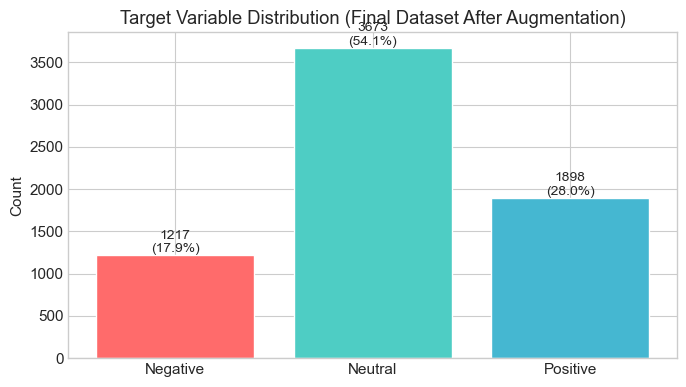

In [58]:
# visualization of the target variable distribution after augmentation
plt.figure(figsize=(7, 4))
labels = [label_map[i] for i in [1, 2, 3]]
values = [counts.get(i, 0) for i in [1, 2, 3]]

bars = plt.bar(labels, values, color=["#ff6b6b", "#4ecdc4", "#45b7d1"], edgecolor="white")
plt.title("Target Variable Distribution (Final Dataset After Augmentation)")
plt.ylabel("Count")

for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v, f"{v}\n({v/total*100:.1f}%)",
             ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


### TF–IDF Feature Construction and Vectorization
In this step, we transformed the final augmented text data into a numerical feature space using TF–IDF vectorization. The vectorizer was fitted only on the augmented training set to prevent information leakage, and then applied consistently to the validation and test sets. By incorporating both unigrams and bigrams, filtering out very rare (min_df = 3) and overly frequent (max_df = 0.9) terms, and limiting the feature space to 15,000 features, we balanced representational richness with dimensionality control. The resulting feature matrices share a consistent dimensionality of 5,493 terms across training, validation, and test splits, ensuring that all models are trained and evaluated using the same vocabulary and feature space.



In [59]:
# processing feature space and vectorization for the final augmented dataset
# final split
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=stopwords_list,
    max_df=0.9,
    min_df=3,
    ngram_range=(1, 2),
    max_features=15000
)

X_train_vec = vectorizer.fit_transform(X_train_aug)
X_val_vec   = vectorizer.transform(X_val_split)
X_test_vec  = vectorizer.transform(X_test_split)

y_train = y_train_aug
y_val   = y_val_split
y_test  = y_test_split

print("X_train_vec shape:", X_train_vec.shape)
print("X_val_vec shape:", X_val_vec.shape)
print("X_test_vec shape:", X_test_vec.shape)


X_train_vec shape: (4997, 6065)
X_val_vec shape: (600, 6065)
X_test_vec shape: (1200, 6065)


# Part 2: Model Exploration

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

## Linear Model

We explored logistic regression models as our linear modeling approach, which is well suited for high-dimensional sparse text data generated by TF-IDF vectorization. We systematically compared no regularization, L1, and L2 regularization and performed grid search over key hyperparameters Hyperparameter tuning was guided by cross-validated macro-F1 scores rather than test performance.

**Parameter Settings and Tuning Process**
- No-penalty Logistic Regression: We first fit a logistic regression model without any regularization to establish a baseline. This model used the lbfgs solver, balanced class weights to account for class imbalance, and an increased maximum number of iterations to ensure convergence. Because no regularization was applied, this model relied entirely on the raw TF-IDF feature weights.
- Ridge (L2) Logistic Regression: Next, we introduced L2 regularization and tuned the regularization strength parameter C using 5-fold cross-validation. We evaluated C ∈ {0.01, 0.1, 1, 10, 100} and selected the optimal value based on macro-averaged F1 score, which equally weights performance across all sentiment classes. This tuning process allows us to balance bias and variance while improving generalization.
- Lasso (L1) Logistic Regression: Finally, we explored L1 regularization using the saga solver, again tuning the same grid of C values with macro-F1 as the optimization metric. L1 regularization performs implicit feature selection by shrinking some coefficients to zero, which can be beneficial for interpretability but may discard weak yet informative features in text data.

- Across all models, we used identical training and test splits and consistent evaluation metrics to ensure fair comparison.

In [61]:
target_labels = ["Negative", "Neutral", "Positive"]
C_grid = [0.01, 0.1, 1, 10, 100]

### Logistic Regression (no penalty)

In [62]:
lr_none = LogisticRegression(
    penalty=None,
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)

lr_none.fit(X_train_vec, y_train)
y_pred = lr_none.predict(X_test_vec)

print("Logistic Regression (No penalty)")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test Macro-F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_labels))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression (No penalty)
Test Accuracy: 0.662
Test Macro-F1: 0.501
Classification report:
              precision    recall  f1-score   support

    Negative       0.23      0.15      0.18        84
     Neutral       0.73      0.78      0.75       736
    Positive       0.59      0.55      0.57       380

    accuracy                           0.66      1200
   macro avg       0.51      0.49      0.50      1200
weighted avg       0.65      0.66      0.65      1200

Confusion matrix:
[[ 13  50  21]
 [ 36 574 126]
 [  8 164 208]]


### Logistic Regression (Ridge)

In [63]:
lr_l2 = GridSearchCV(
    LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ),
    param_grid={"C": C_grid},
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

lr_l2.fit(X_train_vec, y_train)
y_pred = lr_l2.predict(X_test_vec)

print("Logistic Regression (Ridge/L2)")
print(f"Best params: {lr_l2.best_params_}")
print(f"Best CV Macro-F1: {lr_l2.best_score_:.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test Macro-F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_labels))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))



Logistic Regression (Ridge/L2)
Best params: {'C': 1}
Best CV Macro-F1: 0.721
Test Accuracy: 0.709
Test Macro-F1: 0.570
Classification report:
              precision    recall  f1-score   support

    Negative       0.32      0.24      0.27        84
     Neutral       0.79      0.78      0.78       736
    Positive       0.63      0.68      0.65       380

    accuracy                           0.71      1200
   macro avg       0.58      0.57      0.57      1200
weighted avg       0.70      0.71      0.71      1200

Confusion matrix:
[[ 20  41  23]
 [ 36 573 127]
 [  7 115 258]]


### Logistic Regression (Lasso)

In [64]:
lr_l1 = GridSearchCV(
    LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ),
    param_grid={"C": C_grid},
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

lr_l1.fit(X_train_vec, y_train)
y_pred = lr_l1.predict(X_test_vec)

print("Logistic Regression (Lasso/L1)")
print(f"Best params: {lr_l1.best_params_}")
print(f"Best CV Macro-F1: {lr_l1.best_score_:.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test Macro-F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_labels))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression (Lasso/L1)
Best params: {'C': 1}
Best CV Macro-F1: 0.697
Test Accuracy: 0.692
Test Macro-F1: 0.538
Classification report:
              precision    recall  f1-score   support

    Negative       0.26      0.18      0.21        84
     Neutral       0.77      0.77      0.77       736
    Positive       0.61      0.66      0.63       380

    accuracy                           0.69      1200
   macro avg       0.55      0.53      0.54      1200
weighted avg       0.68      0.69      0.69      1200

Confusion matrix:
[[ 15  47  22]
 [ 35 565 136]
 [  8 122 250]]


**Discussion**
- We evaluated all models using accuracy, macro-F1, class-specific precision/recall/F1, and confusion matrices.
- The no-penalty logistic regression achieved a test accuracy of 0.66 and a macro-F1 of 0.50. While performance on the Neutral class was strong, recall for the Negative class was very low, indicating poor generalization to minority classes.
- The Ridge (L2) model showed the best overall performance, with a test accuracy of 0.71 and a macro-F1 of 0.57. Cross-validation also supported this choice, yielding the highest CV macro-F1 (0.72) among all linear models. This model achieved the most balanced performance across Neutral and Positive classes while modestly improving performance on the Negative class.
- The Lasso (L1) model achieved slightly lower performance (accuracy = 0.69, macro-F1 = 0.54). Although L1 regularization reduces model complexity via feature selection, this appeared to remove some informative n-grams, leading to weaker overall performance compared to L2.
- We prioritize macro-F1 over accuracy because of the imbalanced class distribution, as macro-F1 better reflects performance on the minority Negative class.

## Tree Model

### Random Forest

- We next explored a tree-based model using Random Forests to capture potential non-linear interactions between textual features. We began with a baseline Random Forest using default settings and balanced class weights, which achieved reasonable accuracy but performed poorly on the minority negative class, as reflected by a low macro-F1 score.
- To systematically improve performance, we conducted step-by-step hyperparameter tuning, optimizing macro-F1 to account for class imbalance. Specifically, we tuned the number of trees (n_estimators), tree depth (max_depth), minimum samples required to split a node (min_samples_split), the number of features considered at each split (max_features), and the minimum samples per leaf (min_samples_leaf).

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

#### Baseline

In [66]:
# baseline Random Forest with default parameters
rf_baseline = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 # use all available CPU cores for computation.
)

rf_baseline.fit(X_train_vec, y_train)
y_pred_baseline = rf_baseline.predict(X_test_vec)

print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred_baseline):.3f}")
print(f"Baseline Macro-F1: {f1_score(y_test, y_pred_baseline, average='macro'):.3f}")
print(classification_report(y_test, y_pred_baseline, target_names=["Negative","Neutral","Positive"]))

Baseline Accuracy: 0.712
Baseline Macro-F1: 0.471
              precision    recall  f1-score   support

    Negative       0.15      0.02      0.04        84
     Neutral       0.72      0.91      0.81       736
    Positive       0.71      0.47      0.57       380

    accuracy                           0.71      1200
   macro avg       0.53      0.47      0.47      1200
weighted avg       0.68      0.71      0.68      1200



### Hyperparameter Tuning

In [69]:
# Step 1: Tune number of estimators for Random Forest
n_estimators_list = [50, 100, 200, 300, 500]
results = []

for n in n_estimators_list:
    # Create and train Random Forest with balanced class weights
    rf = RandomForestClassifier(
        n_estimators=n,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_vec, y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test_vec)
    
    # Compute macro F1 score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results.append((n, macro_f1))
    
    # Print results for this n_estimators
    print(f"For n_estimators = {n:>3}, Macro-F1 = {macro_f1:.4f}")

# Find n_estimators with highest macro F1
best_n_estimators = max(results, key=lambda x: x[1])[0]
best_n_est = best_n_estimators
print(f"\nBest n_estimators: {best_n_estimators}")


For n_estimators =  50, Macro-F1 = 0.4879
For n_estimators = 100, Macro-F1 = 0.4712
For n_estimators = 200, Macro-F1 = 0.4813
For n_estimators = 300, Macro-F1 = 0.4751
For n_estimators = 500, Macro-F1 = 0.4723

Best n_estimators: 50


In [70]:
# Step 2: Tune max_depth for Random Forest
# max_depth ~ control tree complexity. 

max_depth_list = [10, 20, 30, 50, 100, None] # None = fully grown trees (may overfit)

results = []

for depth in max_depth_list:
    # Create and train Random Forest with chosen n_estimators
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=depth,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_vec, y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test_vec)
    
    # Compute macro F1 score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results.append((str(depth), macro_f1))
    
    # Print results for this max_depth
    print(f"For max_depth = {depth}, Macro-F1 = {macro_f1:.4f}")

# Find the max_depth with the highest Macro-F1
best_depth_str = max(results, key=lambda x: x[1])[0]
best_depth = None if best_depth_str == 'None' else int(best_depth_str)
print(f"\nBest max_depth: {best_depth}")



For max_depth = 10, Macro-F1 = 0.4951
For max_depth = 20, Macro-F1 = 0.5148
For max_depth = 30, Macro-F1 = 0.5023
For max_depth = 50, Macro-F1 = 0.5027
For max_depth = 100, Macro-F1 = 0.4946
For max_depth = None, Macro-F1 = 0.4879

Best max_depth: 20


In [71]:
# Step 3: Tune min_samples_split for Random Forest
# Higher values prevent trees from splitting on very few samples + reduce overfitting

min_samples_list = [2, 5, 10, 20, 50]
results = []

for ms in min_samples_list:
    # Create and train Random Forest with best n_estimators and max_depth
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_split=ms,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_vec, y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test_vec)
    
    # Compute macro F1 score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results.append((ms, macro_f1))
    
    # Print results for this min_samples_split
    print(f"For min_samples_split = {ms:>2}, Macro-F1 = {macro_f1:.4f}")

# Find the min_samples_split with the highest macro-F1
best_split = max(results, key=lambda x: x[1])[0]
print(f"\nBest min_samples_split: {best_split}")


For min_samples_split =  2, Macro-F1 = 0.5148
For min_samples_split =  5, Macro-F1 = 0.5233
For min_samples_split = 10, Macro-F1 = 0.5068
For min_samples_split = 20, Macro-F1 = 0.5015
For min_samples_split = 50, Macro-F1 = 0.5133

Best min_samples_split: 5


In [72]:
# Step 4: Tune max_features for Random Forest
# max_features controls how many features each tree considers at each split.
# Fewer features -> more diverse trees -> less overfitting but risk underfitting.

max_features_list = ['sqrt', 'log2', 0.1, 0.3, 0.5] # 0.1, 0.3, 0.5 ~ use a fraction of the total features (10%, 30%, 50%) at each split
results = []

for mf in max_features_list:
    # Create and train Random Forest with best previous hyperparameters
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_split=best_split,
        max_features=mf,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_vec, y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test_vec)
    
    # Compute macro f1 score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results.append((str(mf), macro_f1))
    
    # Print results for this max_features value
    print(f"For max_features = {str(mf):>5}, Macro-F1 = {macro_f1:.4f}")

# Find max_features with the highest macro-F1
best_feat_str = max(results, key=lambda x: x[1])[0]

# Convert string back to proper type
best_feat = best_feat_str if best_feat_str in ('sqrt', 'log2') else float(best_feat_str)
print(f"\nBest max_features: {best_feat}")


For max_features =  sqrt, Macro-F1 = 0.5233
For max_features =  log2, Macro-F1 = 0.5017
For max_features =   0.1, Macro-F1 = 0.4823
For max_features =   0.3, Macro-F1 = 0.4882
For max_features =   0.5, Macro-F1 = 0.4735

Best max_features: sqrt


In [73]:
# Step 5: Tune min_samples_leaf for Random Forest
# min_samples_leaf sets the minimum number of samples required in each leaf.
# Higher values prevent very specific leaves + reduce overfitting.

min_leaf_list = [1, 2, 5, 10, 20]
results = []

for ml in min_leaf_list:
    # Create and train Random Forest with the best previous hyperparameters
    rf = RandomForestClassifier(
        n_estimators=best_n_est,
        max_depth=best_depth,
        min_samples_split=best_split,
        max_features=best_feat,
        min_samples_leaf=ml,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_vec, y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test_vec)
    
    # Compute macro F1 score
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results.append((ml, macro_f1))
    
    # Print results for this min_samples_leaf value
    print(f"For min_samples_leaf = {ml:>2}, Macro-F1 = {macro_f1:.4f}")

# Find min_samples_leaf with the highest macro-f1
best_leaf = max(results, key=lambda x: x[1])[0]
print(f"\nBest min_samples_leaf: {best_leaf}")


For min_samples_leaf =  1, Macro-F1 = 0.5233
For min_samples_leaf =  2, Macro-F1 = 0.5242
For min_samples_leaf =  5, Macro-F1 = 0.5118
For min_samples_leaf = 10, Macro-F1 = 0.4879
For min_samples_leaf = 20, Macro-F1 = 0.4646

Best min_samples_leaf: 2


#### Final Best Random Forest Model

In [74]:
# final tuned Random Forest
rf_final = RandomForestClassifier(
    n_estimators=best_n_est,
    max_depth=best_depth,
    min_samples_split=best_split,
    max_features=best_feat,
    min_samples_leaf=best_leaf,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_vec, y_train)
y_pred_rf = rf_final.predict(X_test_vec)

print("Final tuned random forest results: ")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"Macro-F1: {f1_score(y_test, y_pred_rf, average='macro'):.3f}")
print(classification_report(y_test, y_pred_rf, target_names=["Negative","Neutral","Positive"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print(f"\nBest parameters:")
print(f"n_estimators: {best_n_est}")
print(f"max_depth: {best_depth}")
print(f"min_samples_split:{best_split}")
print(f"max_features: {best_feat}")
print(f"min_samples_leaf: {best_leaf}")

Final tuned random forest results: 
Accuracy: 0.666
Macro-F1: 0.524
              precision    recall  f1-score   support

    Negative       0.19      0.24      0.21        84
     Neutral       0.76      0.75      0.76       736
    Positive       0.61      0.60      0.61       380

    accuracy                           0.67      1200
   macro avg       0.52      0.53      0.52      1200
weighted avg       0.68      0.67      0.67      1200


Confusion Matrix:
[[ 20  39  25]
 [ 67 550 119]
 [ 21 130 229]]

Best parameters:
n_estimators: 50
max_depth: 20
min_samples_split:5
max_features: sqrt
min_samples_leaf: 2


**Discussion**

After systematic hyperparameter tuning, the final Random Forest model achieved an accuracy of 0.67 and a macro-F1 score of 0.52 on the held-out test set. Performance differed substantially across sentiment classes. The model performed best on the Neutral class (F1 = 0.76), which is expected given its majority representation in the dataset. Performance on the Positive class was moderate (F1 = 0.61), while the Negative class remained challenging, with a low F1 score (0.21) driven primarily by poor recall. Examination of the confusion matrix shows that many negative tweets were misclassified as Neutral or Positive, indicating that the model struggled to learn reliable decision boundaries for the minority class despite the use of balanced class weights.

**Summary (Acorss Models)**

Based on our results, the linear model (Logistic Regression with L2/Ridge regularization) performs better than the tree-based model (Random Forest) for this task. The Ridge logistic regression achieved higher overall accuracy (= 0.71) and a higher macro-F1 score (= 0.57) compared to the tuned Random Forest (accuracy = 0.67, macro-F1 = 0.52). Because the dataset is class-imbalanced, macro-F1 is the more appropriate metric, and under this criterion the linear model consistently outperformed the tree-based approach. In addition, logistic regression is better suited for high-dimensional, sparse TF-IDF features, allowing it to generalize more stably across classes, whereas the Random Forest tended to over-predict the majority Neutral class despite extensive hyperparameter tuning. Overall, the Ridge logistic regression offers a better balance of performance, model complexity, and interpretability, making it the most appropriate model for this project.

# Part3: Result Analysis


### Linear Models: Top N coefficient features


Within all the logistic models, the ridge model performs the best. The following shows the top N features within the ridge model

In [75]:
# Feature importance analysis
# (Logistic Regression – linear model)

import numpy as np

# get feature names from the TF-IDF vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# class labels used throughout the project
target_labels = ["Negative", "Neutral", "Positive"]

def show_top_features_logreg(model, top_n=15):
    """
    Print the top positive and negative features for each class
    in a multiclass Logistic Regression model.
    
    Positive coefficients indicate stronger association with the class.
    Negative coefficients indicate association against the class.
    """
    
    coefs = model.coef_  # shape: (n_classes, n_features)

    for class_idx, class_name in enumerate(target_labels):
        print(f"-"*100)
        print(f"Top features for class: {class_name}")

        # sort coefficients for this class
        sorted_idx = np.argsort(coefs[class_idx])

        top_negative = sorted_idx[:top_n]
        top_positive = sorted_idx[-top_n:][::-1]

        print("\nTop positve features:")
        for idx in top_positive:
            print(f"  {feature_names[idx]:<25} {coefs[class_idx][idx]:.4f}")

        print("\nTop negative features:")
        for idx in top_negative:
            print(f"  {feature_names[idx]:<25} {coefs[class_idx][idx]:.4f}")

# use the best Ridge (L2) Logistic Regression model
show_top_features_logreg(lr_l2.best_estimator_, top_n=15)


----------------------------------------------------------------------------------------------------
Top features for class: Negative

Top positve features:
  autism                    3.5343
  vaccines                  2.9729
  kids                      2.6491
  children                  2.5242
  measles                   2.3555
  child                     2.2647
  not                       2.2466
  cdc                       2.1205
  cdcwhistleblower          1.8620
  flu                       1.8556
  vaccinations              1.8091
  mmr                       1.6056
  never                     1.6048
  brain                     1.5970
  mercury                   1.4833

Top negative features:
  moderna                   -4.4310
  covaxin                   -4.2247
  sputnikv                  -3.9771
  covid                     -3.3655
  pfizerbiontech            -3.0363
  covidvaccine              -1.9574
  india                     -1.8950
  today                     -1.8364
  firs

**Interpretation of Feature Importance (Logistic Regression)**
- The feature weights from the Ridge logistic regression model reveal clear and intuitive patterns across sentiment classes. Negative sentiment is strongly associated with terms such as “autism,” “mercury,” “brain,” “cdcwhistleblower,” and references to children and MMR, which commonly appear in vaccine safety concerns and misinformation narratives. In contrast, mentions of specific COVID-19 vaccines (e.g., Moderna, Pfizer-BioNTech, Sinovac, Sputnik V) tend to push predictions away from the negative class, suggesting these terms are more often used in factual or neutral contexts.
- For the Neutral class, the most influential features reflect informational language, including vaccine names, geopolitical references (e.g., India, EU, minister), and quantitative terms such as “million” and “doses.” Emotionally evaluative words like “grateful,” “thanks,” “effective,” and “safe” are negatively weighted, indicating that neutral tweets are primarily descriptive rather than opinionated.
- The Positive class is characterized by affirmative language such as “grateful,” “thank,” “thanks,” “effective,” “great,” and “getvaccinated,” as well as positive mentions of vaccine brands. Words related to skepticism or negation (e.g., “not,” “autism,” “kids,” “cdc”) push predictions away from the positive class.
- Overall, these patterns suggest that the model is capturing meaningful linguistic signals and can clearly distinguish between negative safety concerns, neutral informational reporting and positive vaccine endorsement.

### Tree Models: Top Features based on Feature Importance


- The Random Forest feature importance results show that the model mainly relies on topic-related words rather than sentiment-specific language. Highly ranked features such as “covid,” “vaccines,” “kids,” “autism,” “children,” and vaccine brand names (e.g., “Moderna,” “Covaxin,” “Sputnik V”) indicate that the model is using core vaccine-discussion terms to split the data. Unlike logistic regression, these importance scores do not tell us whether a word pushes a tweet toward a positive or negative sentiment. Instead, the word is useful for classification.
- This helps explain why the Random Forest is slightly less interpretable for sentiment direction, even though it identifies many meaningful, category-relevant keywords.

In [76]:
# extract and rank feature importance from the random forest model
feature_names = vectorizer.get_feature_names_out()

rf_importance_df = (
    pd.DataFrame(
        np.round(rf_final.feature_importances_, 2),
        index=feature_names,
        columns=["importances"]
    ).sort_values(by="importances", ascending=False)
)
rf_importance_df.head(20)

,importances
covid,0.05
kids,0.03
autism,0.03
moderna,0.03
covaxin,0.03
vaccines,0.03
children,0.02
sputnikv,0.02
dose,0.02
not,0.02


### Tree Model Visualization

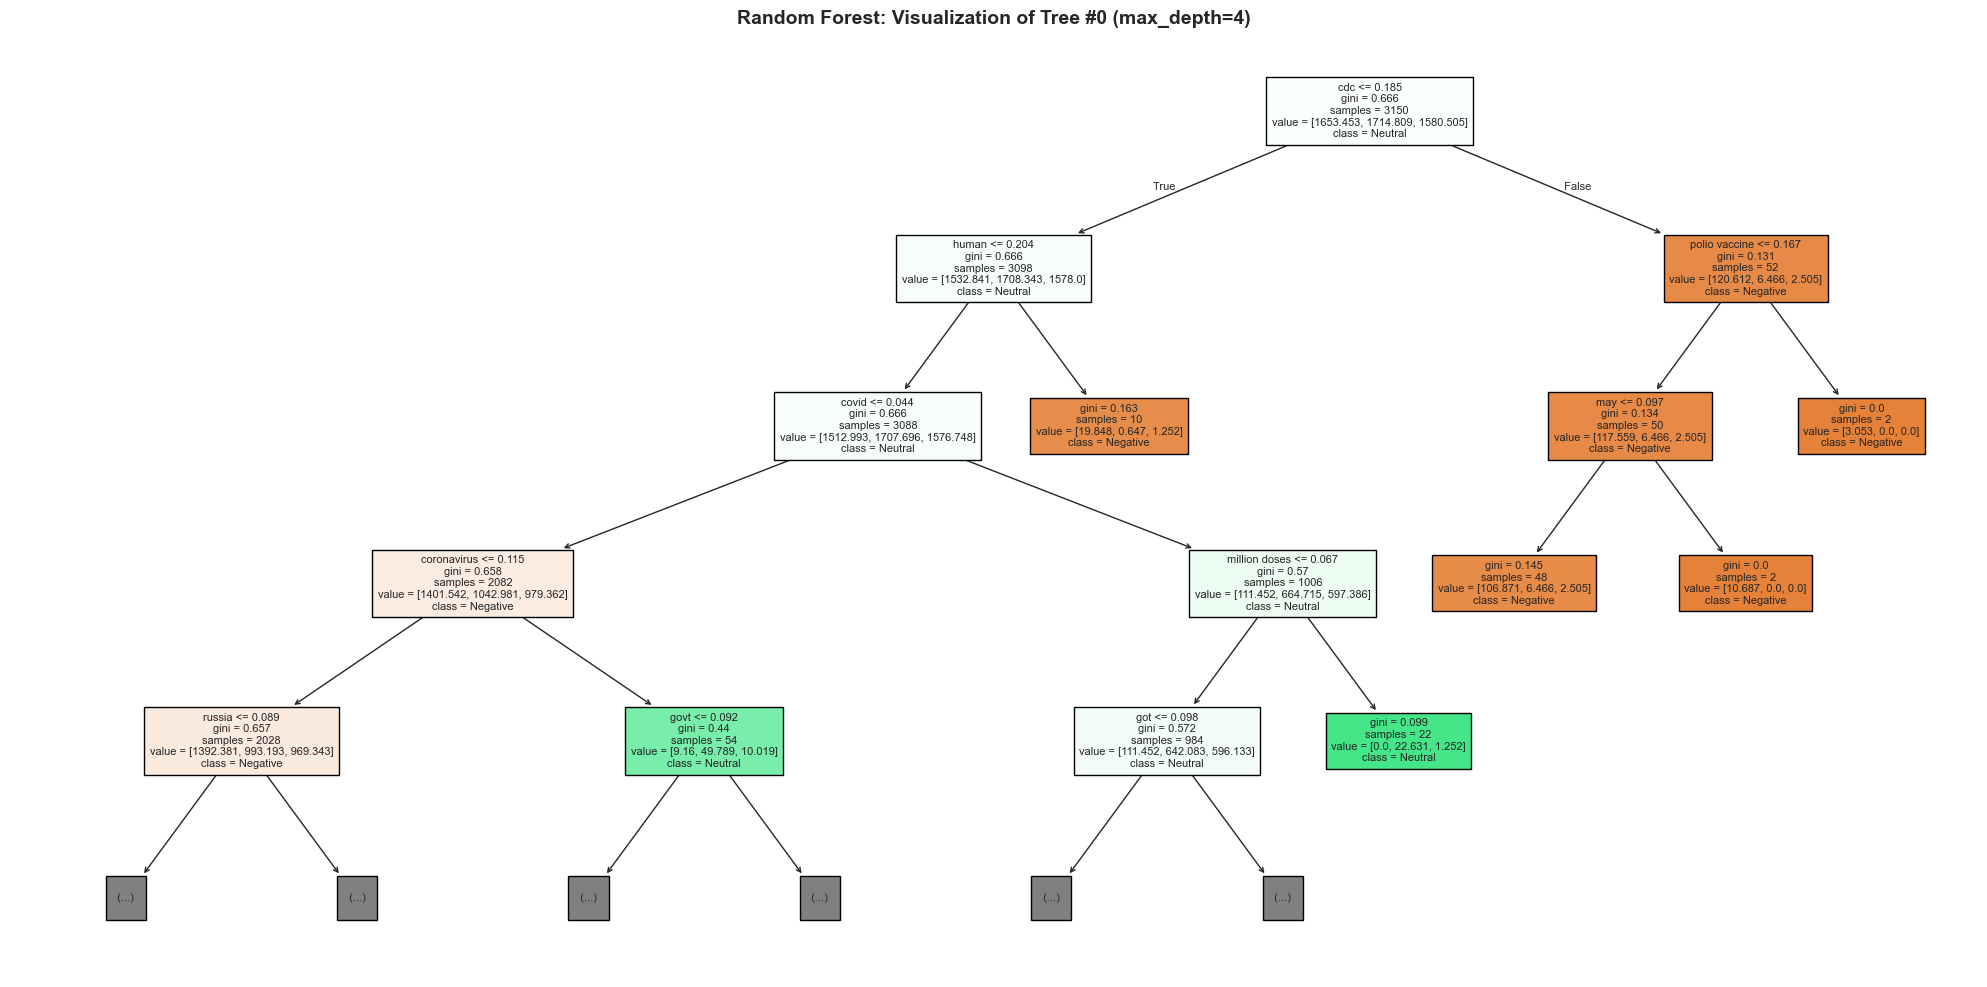

In [77]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# visualize one decision tree from the random forest
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rf_final.estimators_[0],
          feature_names=vectorizer.get_feature_names_out(),
          class_names=["Negative", "Neutral", "Positive"],
          filled=True,
          max_depth=4,
          fontsize=8,
          ax=ax)
plt.title("Random Forest: Visualization of Tree #0 (max_depth=4)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

This visualization shows one representative decision tree from the final tuned Random Forest model, limited to a depth of 4 for interpretability. The tree illustrates how individual words guide sentiment predictions through a series of hierarchical splits. At the root, terms such as “cdc” and “covid” serve as strong early separators, indicating that institutional and informational language is highly influential in the model’s decisions. Branches associated with neutral sentiment tend to include reporting-style terms like “million doses,” “govt,” and “got,” reflecting factual or news-oriented tweets. In contrast, paths leading to negative sentiment often involve words linked to vaccine skepticism or health concerns, such as “polio vaccine” and “coronavirus.” Although positive sentiment is less dominant within this single tree, it is captured across the ensemble as a whole.

## Error Analysis


In [ ]:
# Prepare test df for error analysis
df_test = pd.DataFrame({
    "tweet_text": X_test_split, 
    "y_true": y_test,
    "lr_pred": y_pred,     
    "rf_pred": y_pred_rf     
})

# count misclassified examples
lr_errors = (df_test["y_true"] != df_test["lr_pred"]).sum()
rf_errors = (df_test["y_true"] != df_test["rf_pred"]).sum()

# Show correct vs misclassified examples
print(f"Logistic Regression ~ Misclassified examples: {lr_errors}")
display(df_test[df_test["y_true"] != df_test["lr_pred"]].head()[["tweet_text","y_true","lr_pred"]])

print(f"\nRandom Forest ~ Misclassified examples: {rf_errors}")
display(df_test[df_test["y_true"] != df_test["rf_pred"]].head()[["tweet_text","y_true","rf_pred"]])


Logistic Regression ~ Misclassified examples: 491


,tweet_text,y_true,lr_pred
4662,got to admit moderna second round took me for ...,1,3
1147,covid vaccination coverage in india as of am t...,2,3
3149,vaccination drive in cambodia number of people...,3,2
1823,phase results of covaxin by bharatbiotech demo...,3,2
5042,and it is vaccine day covaxin covishield covid...,3,2



Random Forest ~ Misclassified examples: 401


,tweet_text,y_true,rf_pred
3149,vaccination drive in cambodia number of people...,3,2
5042,and it is vaccine day covaxin covishield covid...,3,2
3466,why wasn t jennifer haller first person in usa...,2,3
766,indigenous vaccine covaxin demonstrates per ce...,2,3
723,we have had a travel advisory against these br...,2,1


Exception ignored in: <function ResourceTracker.__del__ at 0x1030e47c0>
Traceback (most recent call last):
  File "/Users/zehanli/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/zehanli/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/zehanli/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1041487c0>
Traceback (most recent call last):
  File "/Users/zehanli/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/zehanli/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/zehanli/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


In [81]:
# Word-level interpretation for Logistic Regression
import textwrap

# Optional colors for easier visualization
RED = '\033[1;31;48m'
BLUE = '\033[1;34;48m'
END = '\033[1;37;0m'

def interpret_text(text, vectorizer, model, wrap_length=250, use_color=True):
    """
    Annotate each word feature with the learned coefficient, and color based on
    coefficient direction
    Words with positive coefficients are highlighted in blue (positive sentiment),
    negative coefficients in red (negative sentiment).
    """
    annotated = []
    for word in text.split():
        if word in vectorizer.vocabulary_:
            idx = vectorizer.vocabulary_[word]
            coef = model.coef_[0][idx]
            word_str = f"{word}({coef:.3f})"
            if use_color:
                if coef < 0:
                    word_str = RED + word_str + END
                elif coef > 0:
                    word_str = BLUE + word_str + END
            annotated.append(word_str)
        else:
            annotated.append(word)
    
    # Wrap text for better readability
    result = ' '.join(annotated)
    wrapper = textwrap.TextWrapper(width=wrap_length)
    print(wrapper.fill(result))

# view examples
for i, row in df_test[df_test["y_true"] != df_test["lr_pred"]].head(5).iterrows():
    print(f"True label: {row['y_true']}, Predicted: {row['lr_pred']}\n")
    interpret_text(row["tweet_text"], vectorizer, lr_none)
    print("-" * 100)



True label: 1, Predicted: 3

got(-18.201) to admit moderna(-101.015) second(-6.301) round(-3.712) took(-11.354) me for a quite(-7.411) a ride there
overnight(0.425) they weren t messing around(1.678) with these vaccines(32.846)
----------------------------------------------------------------------------------------------------
True label: 2, Predicted: 3

covid(-49.294) vaccination(9.012) coverage(-12.454) in india(-30.156) as of am total(-6.866) beneficiaries(-1.382)
vaccinated(10.716) were vaccinated(10.716) in last(-2.529) hours(5.772) for st(-42.990) dose(-28.036) for nd(-16.198)
dose(-28.036) covid(-49.294) coronaviruspandemic(-1.783) covid(-49.294) vaccine(16.335) pfizervaccine(10.112)
covaxin(-75.827) india(-30.156)
----------------------------------------------------------------------------------------------------
True label: 3, Predicted: 2

vaccination(9.012) drive(-8.263) in cambodia(-5.355) number(-15.009) of people(13.604) voluntary(-10.550) for
sinopharm(-32.569) covid(-4

**Discussion**
- Logistic regression misclassified 349 test examples, while the random forest misclassified 401, indicating that the linear model performs slightly more consistently overall.
- When examining the error examples of the logisitc regrssion closely. These errors highlight that the model is driven by strong keyword weights rather than the meaning of full sentences.
    - Neutral -> Positive (1 -> 3): In the first example, words such as 'vaccines' and 'around' have very strong positive weights, which overpower the mixed or experiential tone ('took me for a ride'), resulting in the model over-predicting positive sentiment.
    - Neutral -> Positive (2 -> 3): Even though the tweet reports trial results (neutral/news-like), highly positive terms such as 'disease', 'severe', 'efficacy', and 'vaccine' dominate, leading to a positive prediction.
    - Positive -> Neutral (3 -> 2): In the Cambodia and Covaxin examples, positive or supportive content is diluted by neutral or negative context words (e.g. country names, dates, 'drive', 'dose'), causing the model to predict Neutral.
- Even though we use TF-IDF instead of raw word counts, the model still treats words as independent features. Each token contributes additively to the prediction, so a few highly weighted words can dominate the decision and lead to errors when the overall context suggests a different sentiment.
- We do not perform word-level coefficient attribution for the random forest model because tree-based models do not assign signed, additive weights to individual features. Instead, we interpret the random forest using feature importance rankings and tree visualizations, which are more appropriate for understanding its decision process.

**Error Comparison and Comparison**
- When we compare the errors across models, the logistic regression model generally makes fewer mistakes than the random forest, but for a specific reason: it relies heavily on a few highly weighted words. Because it is a linear TF-IDF model, certain keywords (such as vaccine names or words like “effective”) can strongly push the prediction, even when the overall tone of the tweet is neutral. This causes frequent confusion between neutral and positive tweets, especially for news-style posts that report vaccination updates without clear sentiment.
- The random forest, on the other hand, makes more total errors and struggles most with the negative class. While tree-based models can capture nonlinear patterns, they are not well suited for sparse, high-dimensional text features, and they tend to favor the majority neutral class. As a result, subtle sentiment cues are often missed, leading to misclassification.

**Potential Improvement**

Based on our exploration, some possible improvements are:
1. Expand negative samples or apply data augmentation to reduce class imbalance
2. Use stronger text representations (e.g., BERT/RoBERTa)
3. Add character n‑grams to handle misspellings and informal language
4. Calibrate decision thresholds per class
5. Use stricter cross‑validation and emphasize macro‑F1 for model selection

# Summary and Conclusion:


Our original research question is: **How did public sentiment toward COVID‑19 vaccines evolve on Twitter from 2020 to 2021?**
To answer this question, We selected the best‑performing model in our study (Ridge Logistic Regression) and applied it to an unlabeled dataset, COVID‑19 All Vaccines Tweets (Gabriel Preda). This dataset contains vaccine‑related tweets from 2020–2021. By predicting sentiment labels and aggregating our results over time, we track how public sentiment about vaccines changed across this period.






In [84]:
# ============================================================
# Summary & Conclusion: Apply Best Model to Unlabeled Dataset
# ============================================================
# Prerequisite: All previous cells have been run (vectorizer, lr_l2 are fitted)
# This code applies the Ridge LR model to the Gabriel Preda
# "COVID-19 All Vaccines Tweets" dataset for temporal analysis.
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

# ------ 1. Load the unlabeled dataset ------
# ⚠️  Adjust the path to your local file
df_unlabeled = pd.read_csv(
    "/Users/zehanli/Course_Uchicago/Winter_2025/MACS30100/Final_project/vaccination_all_tweets.csv",
    encoding="latin1"
)

print("Unlabeled dataset shape:", df_unlabeled.shape)
print("Columns:", df_unlabeled.columns.tolist())
df_unlabeled.head()



Unlabeled dataset shape: (228207, 16)
Columns: ['id', 'user_name', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'text', 'hashtags', 'source', 'retweets', 'favorites', 'is_retweet']


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,elið±ð¹ðªðºð,Your Bed,"heil, hydra ðâº",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [ ]:
# ------ 2. Identify text and date columns ------
# The Gabriel Preda dataset typically uses 'text' and 'date';
# adjust if your column names differ.

# Auto-detect text column
text_col = None
for c in ['text', 'tweet_text', 'tweet', 'content']:
    if c in df_unlabeled.columns:
        text_col = c
        break
print(f"Using text column: '{text_col}'")

# Auto-detect date column
date_col = None
for c in ['date', 'created_at', 'timestamp', 'datetime']:
    if c in df_unlabeled.columns:
        date_col = c
        break
print(f"Using date column: '{date_col}'")

# Parse dates
df_unlabeled[date_col] = pd.to_datetime(df_unlabeled[date_col], errors='coerce')
df_unlabeled = df_unlabeled.dropna(subset=[text_col, date_col]).reset_index(drop=True)
print(f"Samples after dropping nulls: {len(df_unlabeled)}")
print(f"Date range: {df_unlabeled[date_col].min()} → {df_unlabeled[date_col].max()}")

Using text column: 'text'
Using date column: 'date'
Samples after dropping nulls: 228207
Date range: 2020-12-12 11:55:28 → 2021-11-23 20:58:08


In [ ]:
# ------ 3. Text cleaning (reuse existing pipeline) ------
print("Cleaning text...")
df_unlabeled['cleaned_tweet'] = [
    clean_text_single(t) for t in tqdm(df_unlabeled[text_col].tolist(), desc="Cleaning")
]
df_unlabeled = df_unlabeled[df_unlabeled['cleaned_tweet'].str.len() > 0].reset_index(drop=True)
print(f"Samples after cleaning: {len(df_unlabeled)}")

Cleaning text...


Cleaning: 100%|██████████| 228207/228207 [00:19<00:00, 11705.63it/s]


Samples after cleaning: 228193


In [ ]:
# ------ 4. Vectorize & Predict ------
X_unlabeled_vec = vectorizer.transform(df_unlabeled['cleaned_tweet'])

best_model = lr_l2.best_estimator_
df_unlabeled['predicted_label'] = best_model.predict(X_unlabeled_vec)

# Also get predicted probabilities for richer analysis
proba = best_model.predict_proba(X_unlabeled_vec)
df_unlabeled['prob_negative'] = proba[:, 0]
df_unlabeled['prob_neutral']  = proba[:, 1]
df_unlabeled['prob_positive'] = proba[:, 2]

label_map = {1: "Negative", 2: "Neutral", 3: "Positive"}
df_unlabeled['sentiment'] = df_unlabeled['predicted_label'].map(label_map)

print("\nOverall predicted sentiment distribution:")
print(df_unlabeled['sentiment'].value_counts())
print(df_unlabeled['sentiment'].value_counts(normalize=True).round(3))


Overall predicted sentiment distribution:
sentiment
Neutral     154138
Positive     50731
Negative     23324
Name: count, dtype: int64
sentiment
Neutral     0.675
Positive    0.222
Negative    0.102
Name: proportion, dtype: float64


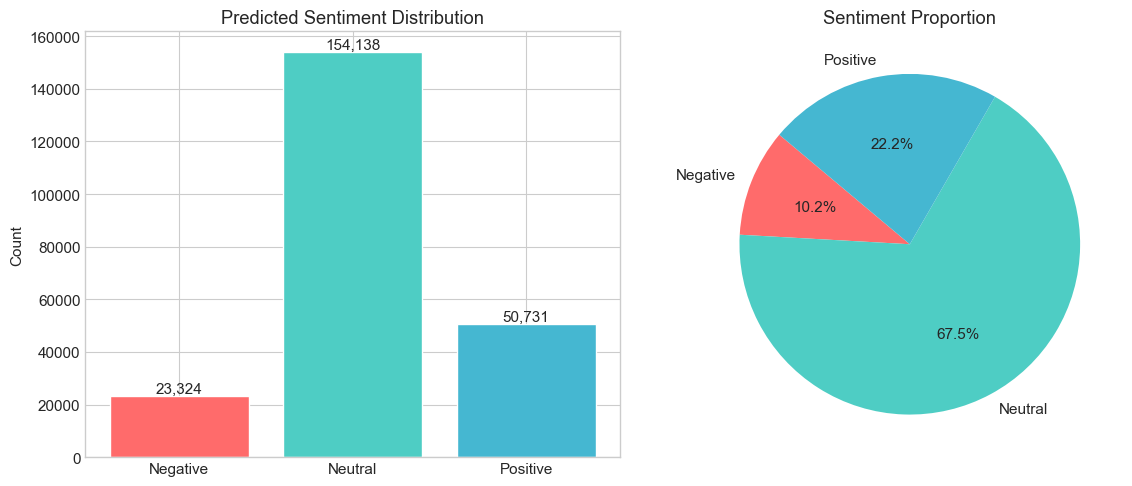

In [ ]:
# ------ 5. Overall Sentiment Distribution (Pie + Bar) ------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors_map = {"Negative": "#ff6b6b", "Neutral": "#4ecdc4", "Positive": "#45b7d1"}
counts = df_unlabeled['sentiment'].value_counts().reindex(["Negative", "Neutral", "Positive"])
bars = axes[0].bar(counts.index, counts.values,
                   color=[colors_map[s] for s in counts.index], edgecolor='white')
for bar, val in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f"{val:,}", ha='center', va='bottom', fontsize=11)
axes[0].set_ylabel("Count")
axes[0].set_title("Predicted Sentiment Distribution")

# Pie chart
axes[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%',
            colors=[colors_map[s] for s in counts.index],
            startangle=140, textprops={'fontsize': 11})
axes[1].set_title("Sentiment Proportion")

plt.tight_layout()
plt.savefig("fig_overall_sentiment.png", dpi=150, bbox_inches='tight')
plt.show()

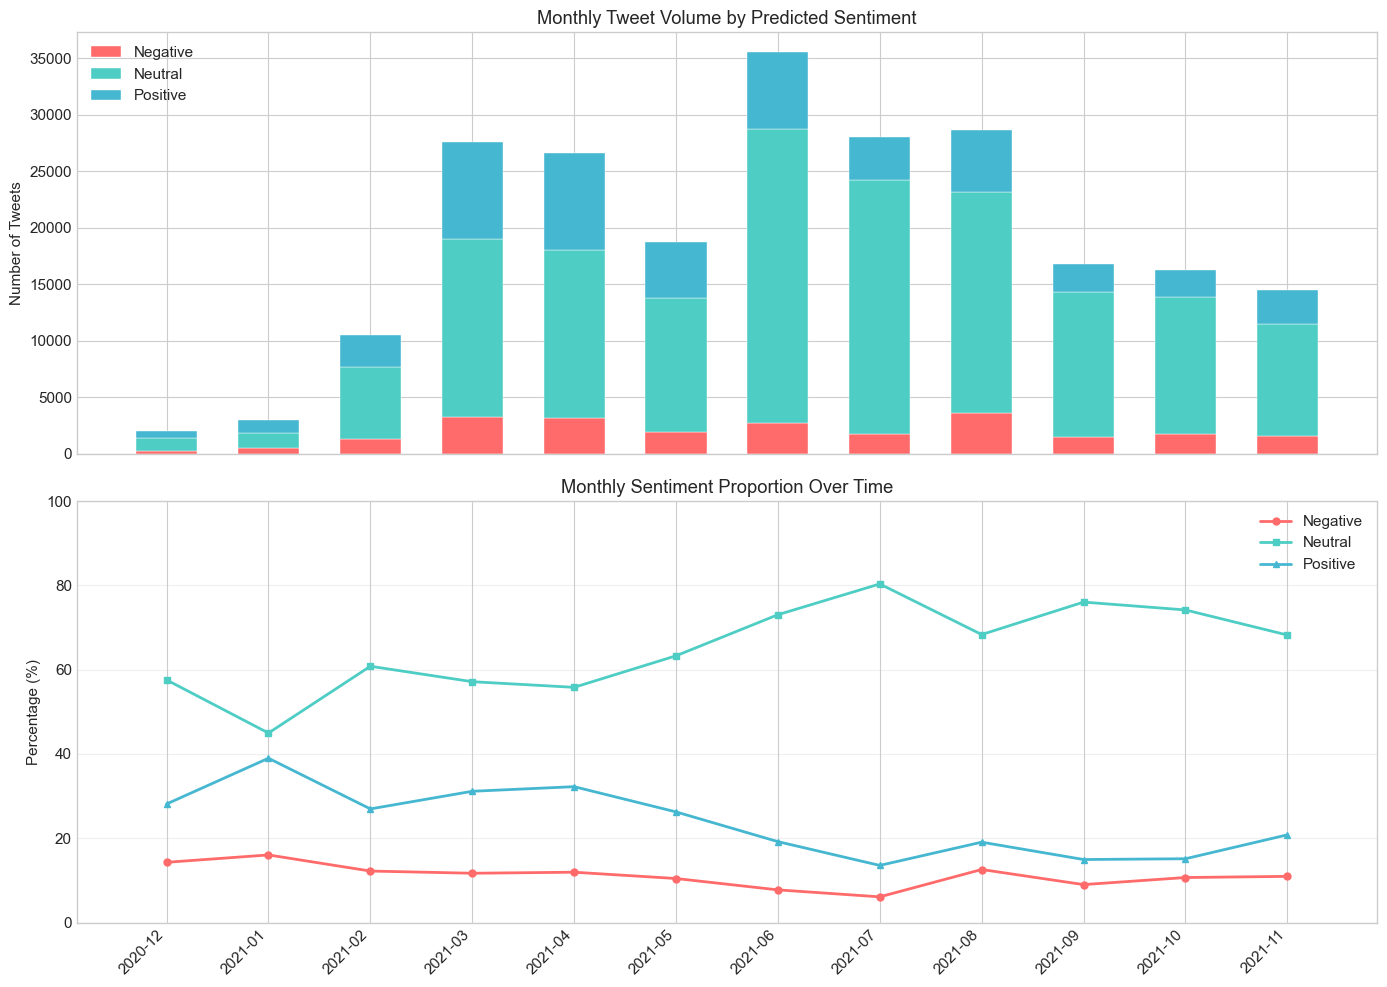

In [ ]:
# ------ 6. Monthly Sentiment Trend ------
df_unlabeled['year_month'] = df_unlabeled[date_col].dt.to_period('M')

monthly = (
    df_unlabeled
    .groupby(['year_month', 'sentiment'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=["Negative", "Neutral", "Positive"], fill_value=0)
)

# Convert to proportions
monthly_pct = monthly.div(monthly.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# (a) Stacked bar – raw counts
x_labels = monthly.index.astype(str)
x = np.arange(len(x_labels))
w = 0.6

bottom_neg = np.zeros(len(x))
for sent, color in [("Negative", "#ff6b6b"), ("Neutral", "#4ecdc4"), ("Positive", "#45b7d1")]:
    vals = monthly[sent].values
    axes[0].bar(x, vals, w, bottom=bottom_neg, label=sent, color=color, edgecolor='white', linewidth=0.3)
    bottom_neg += vals

axes[0].set_ylabel("Number of Tweets")
axes[0].set_title("Monthly Tweet Volume by Predicted Sentiment")
axes[0].legend(loc='upper left')

# (b) Line chart – proportion over time
for sent, color, marker in [("Negative", "#ff6b6b", "o"),
                             ("Neutral", "#4ecdc4", "s"),
                             ("Positive", "#45b7d1", "^")]:
    axes[1].plot(x, monthly_pct[sent].values, marker=marker, color=color,
                 label=sent, linewidth=2, markersize=5)

axes[1].set_ylabel("Percentage (%)")
axes[1].set_title("Monthly Sentiment Proportion Over Time")
axes[1].set_xticks(x)
axes[1].set_xticklabels(x_labels, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("fig_monthly_sentiment_trend.png", dpi=150, bbox_inches='tight')
plt.show()


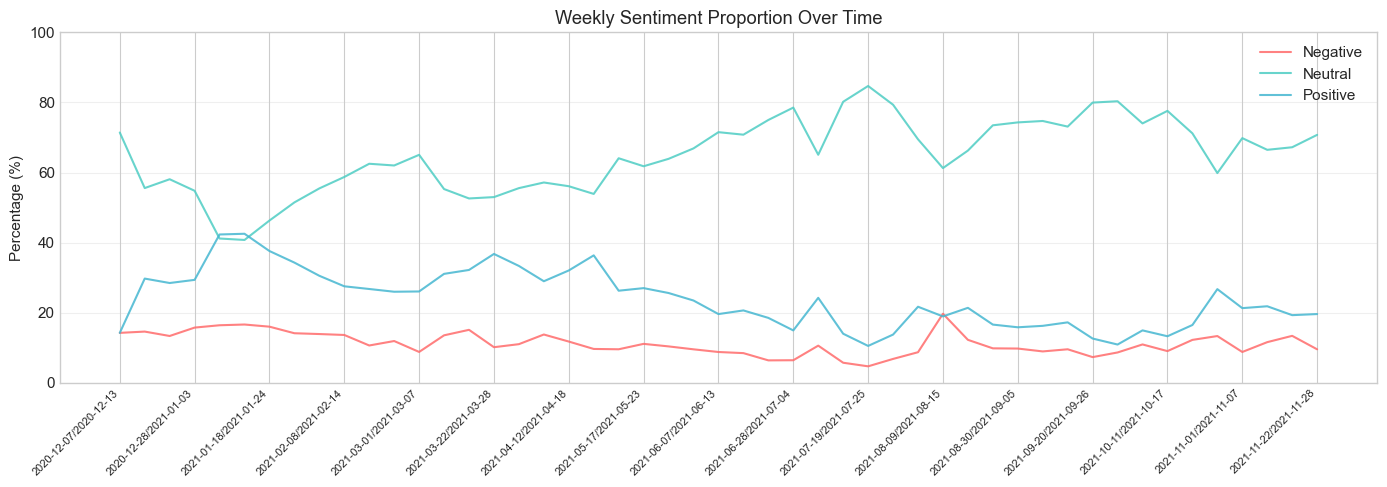

In [ ]:
# ------ 7. Weekly Sentiment Trend (smoother view) ------
df_unlabeled['week'] = df_unlabeled[date_col].dt.to_period('W')

weekly = (
    df_unlabeled
    .groupby(['week', 'sentiment'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=["Negative", "Neutral", "Positive"], fill_value=0)
)
weekly_pct = weekly.div(weekly.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 5))
x_w = np.arange(len(weekly_pct))

for sent, color in [("Negative", "#ff6b6b"), ("Neutral", "#4ecdc4"), ("Positive", "#45b7d1")]:
    ax.plot(x_w, weekly_pct[sent].values, color=color, label=sent, linewidth=1.5, alpha=0.85)

# Show every 4th week label to avoid crowding
tick_step = max(1, len(weekly_pct) // 15)
ax.set_xticks(x_w[::tick_step])
ax.set_xticklabels(weekly_pct.index.astype(str)[::tick_step], rotation=45, ha='right', fontsize=8)

ax.set_ylabel("Percentage (%)")
ax.set_title("Weekly Sentiment Proportion Over Time")
ax.legend()
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("fig_weekly_sentiment_trend.png", dpi=150, bbox_inches='tight')
plt.show()



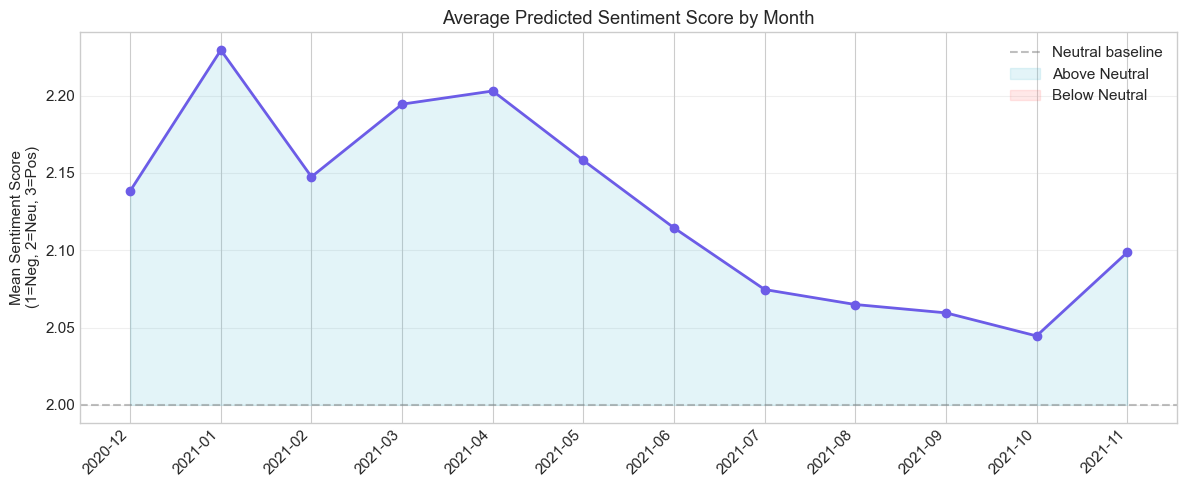

In [ ]:
# ------ 8. Average Sentiment Score Over Time ------
# Map to numeric score: Negative=1, Neutral=2, Positive=3
# Higher = more positive overall
df_unlabeled['sentiment_score'] = df_unlabeled['predicted_label']

monthly_avg = df_unlabeled.groupby('year_month')['sentiment_score'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
x_m = np.arange(len(monthly_avg))
ax.plot(x_m, monthly_avg.values, marker='o', color='#6c5ce7', linewidth=2, markersize=6)
ax.axhline(y=2, color='gray', linestyle='--', alpha=0.5, label='Neutral baseline')
ax.fill_between(x_m, 2, monthly_avg.values,
                where=(monthly_avg.values >= 2), alpha=0.15, color='#45b7d1', label='Above Neutral')
ax.fill_between(x_m, 2, monthly_avg.values,
                where=(monthly_avg.values < 2), alpha=0.15, color='#ff6b6b', label='Below Neutral')

ax.set_xticks(x_m)
ax.set_xticklabels(monthly_avg.index.astype(str), rotation=45, ha='right')
ax.set_ylabel("Mean Sentiment Score\n(1=Neg, 2=Neu, 3=Pos)")
ax.set_title("Average Predicted Sentiment Score by Month")
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("fig_avg_sentiment_score.png", dpi=150, bbox_inches='tight')
plt.show()



In [ ]:
# ------ 9. Summary Statistics Table ------
summary_table = (
    df_unlabeled
    .groupby('year_month')
    .agg(
        total_tweets=('predicted_label', 'count'),
        pct_negative=('predicted_label', lambda x: (x == 1).mean() * 100),
        pct_neutral=('predicted_label', lambda x: (x == 2).mean() * 100),
        pct_positive=('predicted_label', lambda x: (x == 3).mean() * 100),
        avg_score=('sentiment_score', 'mean')
    )
    .round(2)
)

print("\n=== Monthly Sentiment Summary ===")
display(summary_table)


=== Monthly Sentiment Summary ===


,total_tweets,pct_negative,pct_neutral,pct_positive,avg_score
year_month,,,,,
2020-12,1980,14.29,57.58,28.13,2.14
2021-01,3029,16.04,44.97,38.99,2.23
2021-02,10524,12.22,60.81,26.97,2.15
2021-03,27562,11.70,57.15,31.15,2.19
2021-04,26617,11.94,55.81,32.24,2.20
2021-05,18700,10.45,63.29,26.26,2.16
2021-06,35500,7.75,73.05,19.20,2.11
2021-07,28052,6.10,80.34,13.56,2.07
2021-08,28624,12.59,68.34,19.07,2.06


In [ ]:
# ------ 10. Key Milestone Annotations (optional) ------
# You can add key vaccine event annotations here
# e.g., FDA EUA for Pfizer (Dec 11, 2020), Moderna (Dec 18, 2020),
# J&J (Feb 27, 2021), J&J pause (Apr 13, 2021), etc.

print("\n=== Analysis Complete ===")
print(f"Total tweets analyzed: {len(df_unlabeled):,}")
print(f"Date range: {df_unlabeled[date_col].min().date()} to {df_unlabeled[date_col].max().date()}")
print(f"\nOverall distribution:")
print(df_unlabeled['sentiment'].value_counts(normalize=True).round(3).to_string())


=== Analysis Complete ===
Total tweets analyzed: 228,193
Date range: 2020-12-12 to 2021-11-23

Overall distribution:
sentiment
Neutral     0.675
Positive    0.222
Negative    0.102


**Interpretation of Temporal Sentiment Analysis**

We applied the best-performing Ridge Logistic Regression model to 228,193 vaccine-related tweets spanning December 2020 to November 2021. The overall predicted sentiment distribution is dominated by Neutral tweets (67.5%), followed by Positive (22.2%) and Negative (10.2%), indicating that the majority of vaccine-related discourse on Twitter was informational or factual in tone rather than explicitly opinionated.

**Temporal Trends.** The monthly sentiment proportion plot and the average sentiment score reveal a clear two-phase pattern:

- **Early optimism (Dec 2020 – Apr 2021):** The average sentiment score peaked at 2.23 in January 2021, coinciding with the initial rollout of COVID-19 vaccines following the FDA's Emergency Use Authorizations for Pfizer (Dec 11, 2020) and Moderna (Dec 18, 2020). Positive tweets reached their highest share during this period (~39% in January), reflecting public enthusiasm and hope surrounding vaccine availability. Tweet volume also surged dramatically from ~2,000 in December 2020 to over 27,000 by March 2021, as vaccines became a central topic of public discourse.

- **Gradual sentiment decline (May – Nov 2021):** Beginning around May 2021, the positive proportion steadily dropped from ~32% to as low as ~13.6% in July, while the neutral proportion rose sharply to 80.3%. The average sentiment score declined from 2.20 in April to a low of 2.04 in October. This shift coincides with several real-world developments: the J&J vaccine pause (April 13, 2021) over blood clot concerns, growing debates over vaccine mandates, the emergence of the Delta variant, and increasing polarization around booster shots. Notably, the negative proportion hit its lowest point (6.1%) in July 2021 — suggesting that the decline in positivity was driven more by a shift toward neutral/informational discourse than by a rise in explicit negativity.

- **Late-period stabilization (Oct – Nov 2021):** A slight rebound in both positive share (20.8%) and average score (2.10) appeared in November 2021, potentially reflecting renewed public attention to booster campaigns and the approaching holiday season.

**Volume Dynamics.** Tweet volume peaked in June 2021 (35,500 tweets), likely driven by widespread vaccine eligibility expansions and mandate announcements, before declining in the latter half of the year as vaccination became more routine and less newsworthy.

**Summary.** Overall, public sentiment toward COVID-19 vaccines on Twitter followed a trajectory of initial optimism during the early vaccine rollout, followed by a gradual shift toward more neutral, information-driven discourse as the vaccination campaign matured and public debate became more complex. The sentiment never fell below the neutral baseline (score = 2.0) in any month, suggesting that despite growing controversy, the overall tone of vaccine-related tweets remained weakly positive throughout the study period.

# Contribution of Each Group Member

All members (Larissa Xu, Shuting Yang, Sherry Ding, Zehan Li): Collaboratively decided on the project topic and refined the research question; identified and collected relevant datasets; jointly discussed the interpretation of findings and how results answer the research question; co-developed the final result analysis and conclusions.

Larissa & Shuting: Led the exploratory data analysis (EDA), including data cleaning checks, summary statistics, and key visualizations

Sherry & Zehan: Led model exploration, including feature processing, testing multiple models, comparing performance

Overall, each member contribute equally to this project.